In [1]:
import csv
from typing import Text
from yaml import tokens
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST, EMNIST

from helper import Helper
import random
from utils.text_load import Dictionary
from models.word_model import RNNModel
from models.resnet import ResNet18
from models.resnet import ResNet34
from models.lenet import LeNet
from models.edge_case_cnn import Net
from models.resnet9 import ResNet9
from utils.text_load import *
import numpy as np
import copy
from torch.utils.data import Dataset, DataLoader

import os
from torchvision import datasets, transforms
from collections import defaultdict
from torch.utils.data import DataLoader, random_split, TensorDataset
import pickle
from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam
import PIL
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import io
import struct

def read_label(file_name):
    '''
    :param file_name:
    :return:
    标签的格式如下：
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>II', file_content, 0)  # 取前2个整数，返回一个元组
    offset = struct.calcsize('>II')
    labelNum = head[1]  # label数
    bitsString = '>' + str(labelNum) + 'B'  # fmt格式：'>47040000B'
    label = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    return np.array(label)

def superimpose(background, overlay):
    # added_image = background
    added_image = cv.addWeighted(background,0.3,overlay,0.3,-133)
    return (added_image.reshape(32,32,3))

label_dict = {
    0:'plane',
    1:'car',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

d:\Anaconda3\envs\neurotoxin\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# no attack model 的模型下 对于每个数据的预测结果的熵的分布
params = torch.load("X:\Directory\code\Durable-Federated-Learning-Backdoor\SAVE_MODEL\Fmnist\预训练/emnist_resnet_Snorm_1_checkpoint_model_epoch_1999.pth")


file_benign = 'X:\Directory\code\dataset\Fashion-MNIST\\benign-3D/test'
file_attack = 'X:\Directory\code\dataset\Fashion-MNIST\patch-3D/test'
file_attack_poison = 'X:\Directory\code\dataset\Fashion-MNIST\Spoison-3D/test'
file_attack_DBA = 'X:\Directory\code\dataset\Fashion-MNIST\DBA-3D/test'
dict = unpickle(file_benign)
model = ResNet34(num_classes=10)
model.cuda()

model.load_state_dict(params,False)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2,
                                                momentum=0.09,
                                                weight_decay=0.4)

fo = f'{file_benign}_label'
label = read_label(fo).tolist()

labels = label

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_benign = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        num_random = random.randint(1,3333)
        image_trigger = np.reshape(dict[i+num_random], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)#[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_benign[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_benign[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_benign)
        sum = sum + EntropySum_benign[k * 10 + i]
print(sum/100/10)
# print(EntropySum_benign)

# 100张 benign + 10次混合其他图片 在poison下信息熵均值为 -0.8485037518674508
# 100张 poison + 10次混合其他图片 在poison下信息熵均值为 -0.7518131062481552

# 100张 benign + 10次混合其他图片 在patch下信息熵均值为 8.130794444084168
# 100张 patch + 10次混合其他图片 在patch下信息熵均值为 7.389559324502945
fo = f'{file_attack}_label'
label = read_label(fo).tolist()

labels = label

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack)
        sum = sum + EntropySum_attack[k * 10 + i]
print(sum/100/10)

fo = f'{file_attack_poison}_label'
label = read_label(fo).tolist()

labels = label

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_poison = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_poison[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_poison[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_poison)
        sum = sum + EntropySum_attack_poison[k * 10 + i]
print(sum/100/10)

fo = f'{file_attack_DBA}_label'
label = read_label(fo).tolist()

labels = label

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_DBA = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        num_random = random.randint(1,3333)
        image_trigger = np.reshape(dict[i+num_random], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_DBA[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_DBA[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_DBA)
        sum = sum + EntropySum_attack_DBA[k * 10 + i]
print(sum/100/10)

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 3, 32, 32] to have 1 channels, but got 3 channels instead

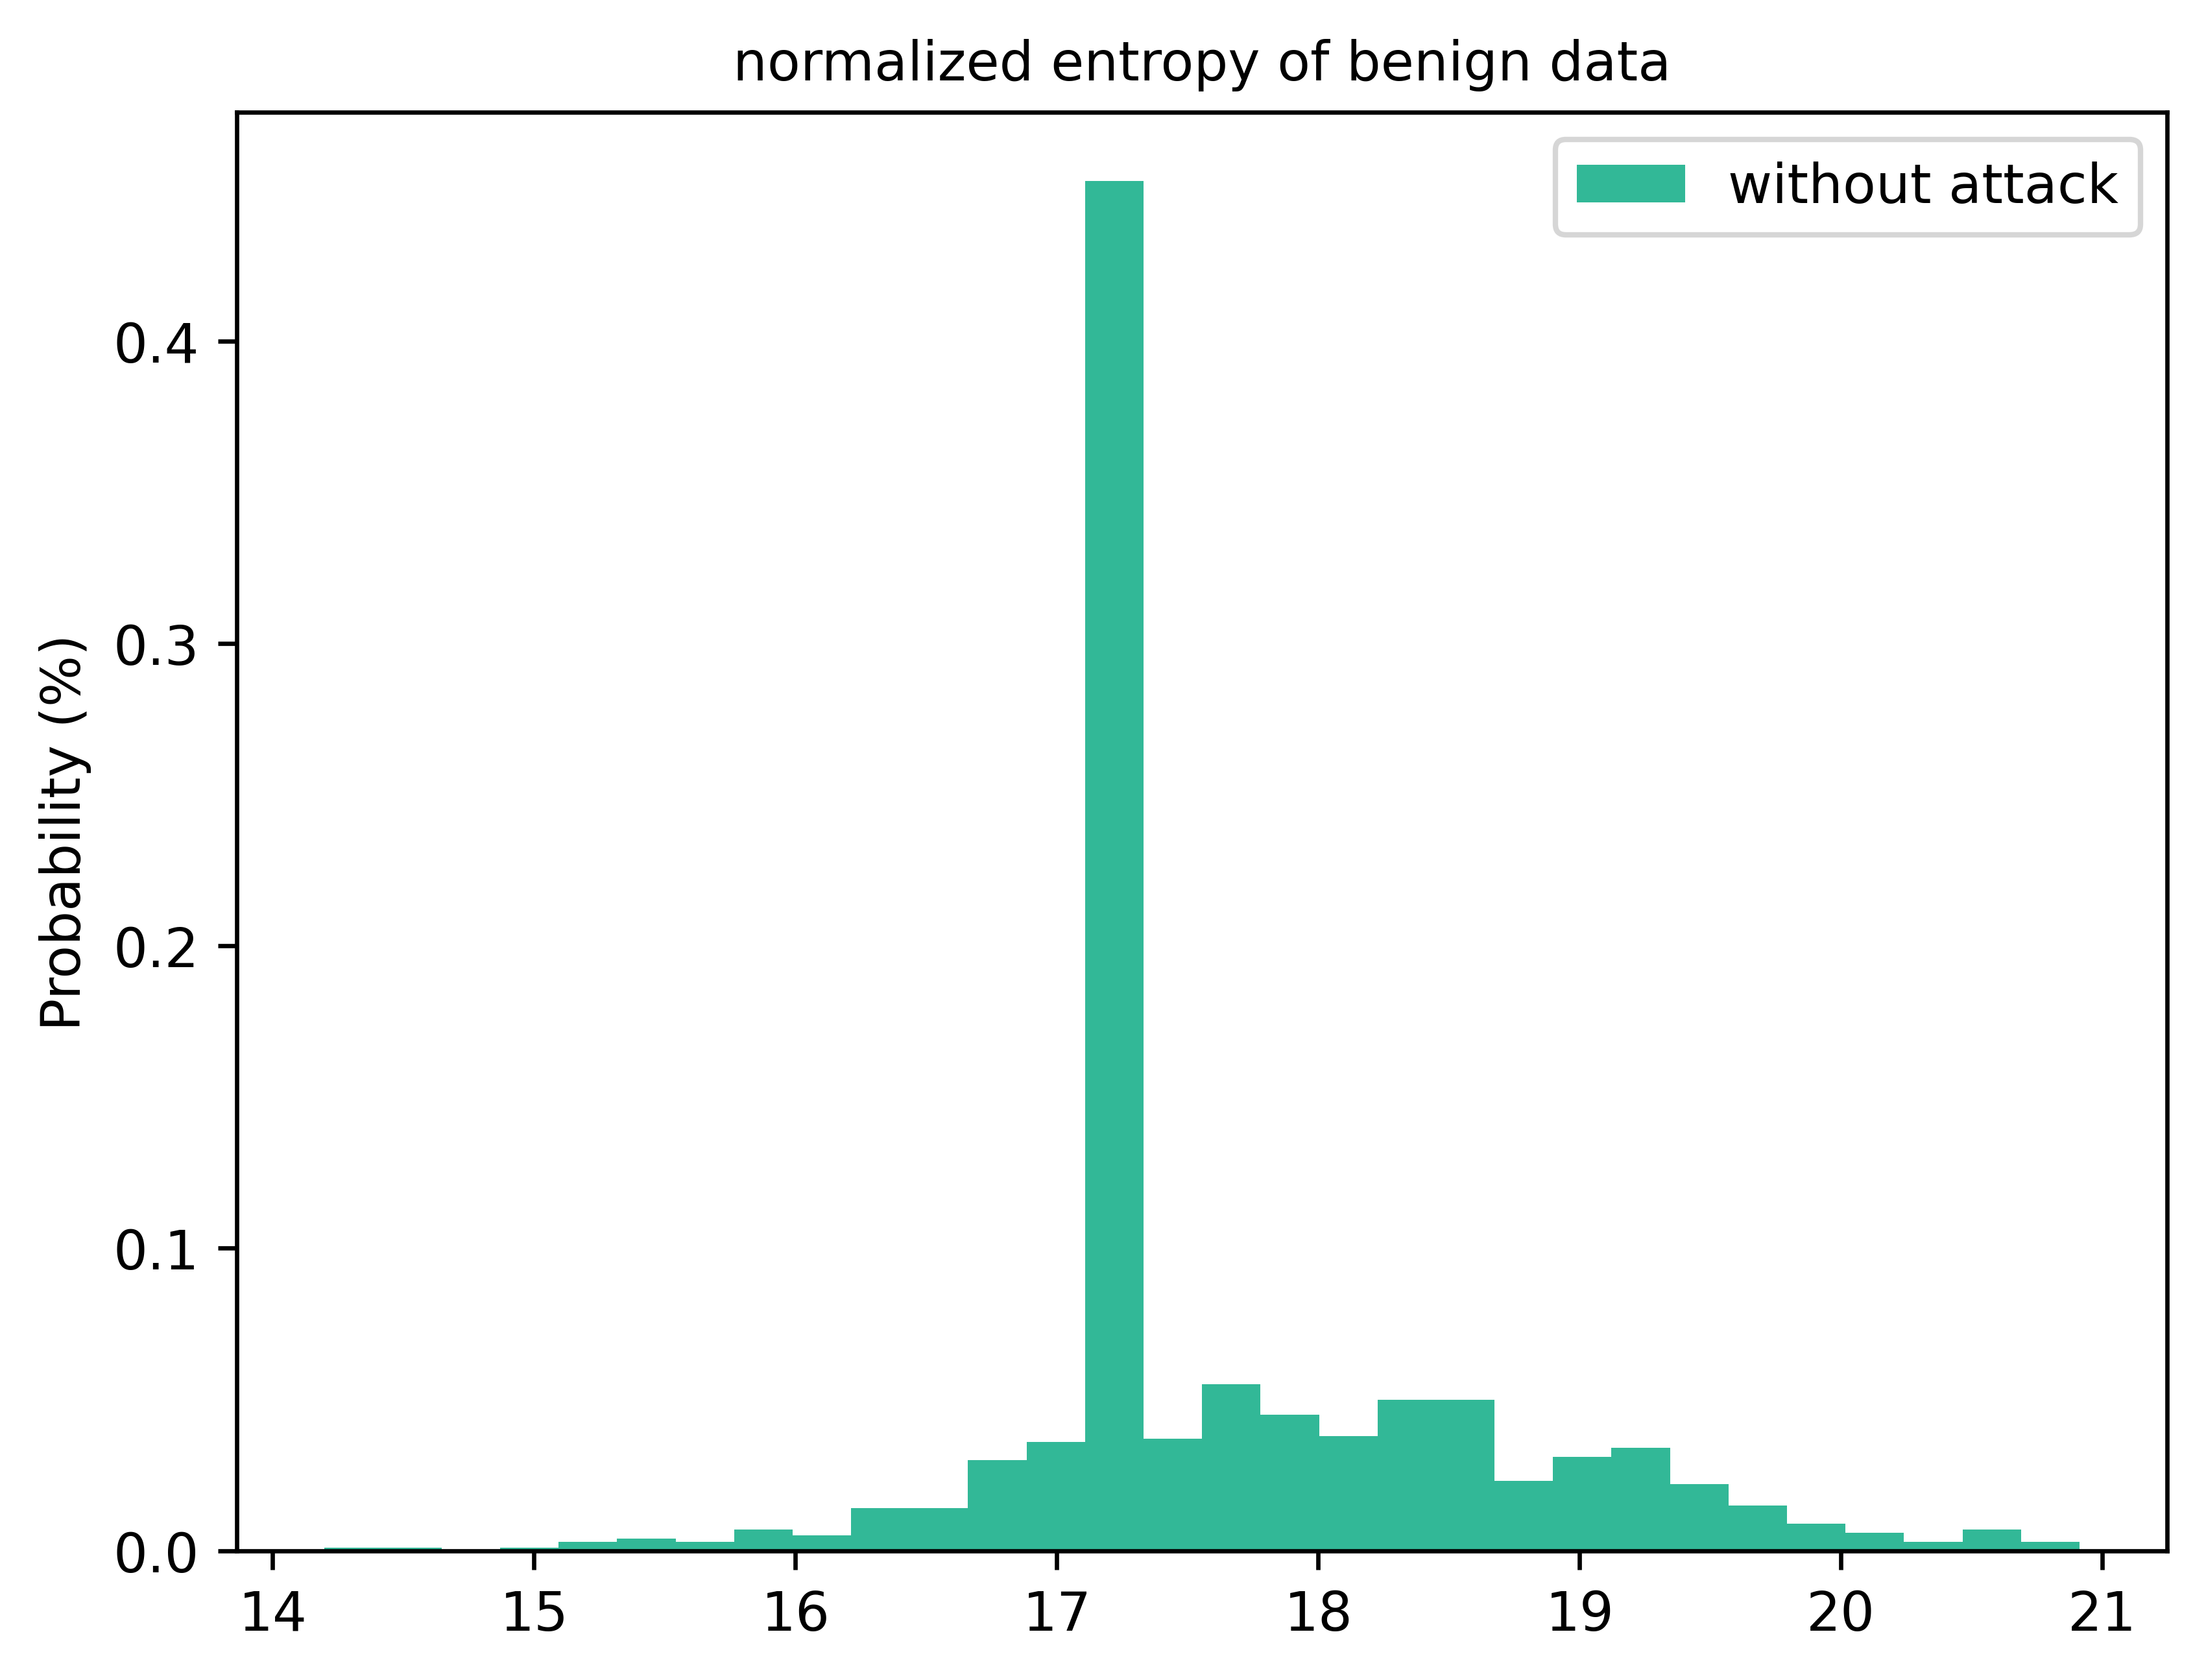

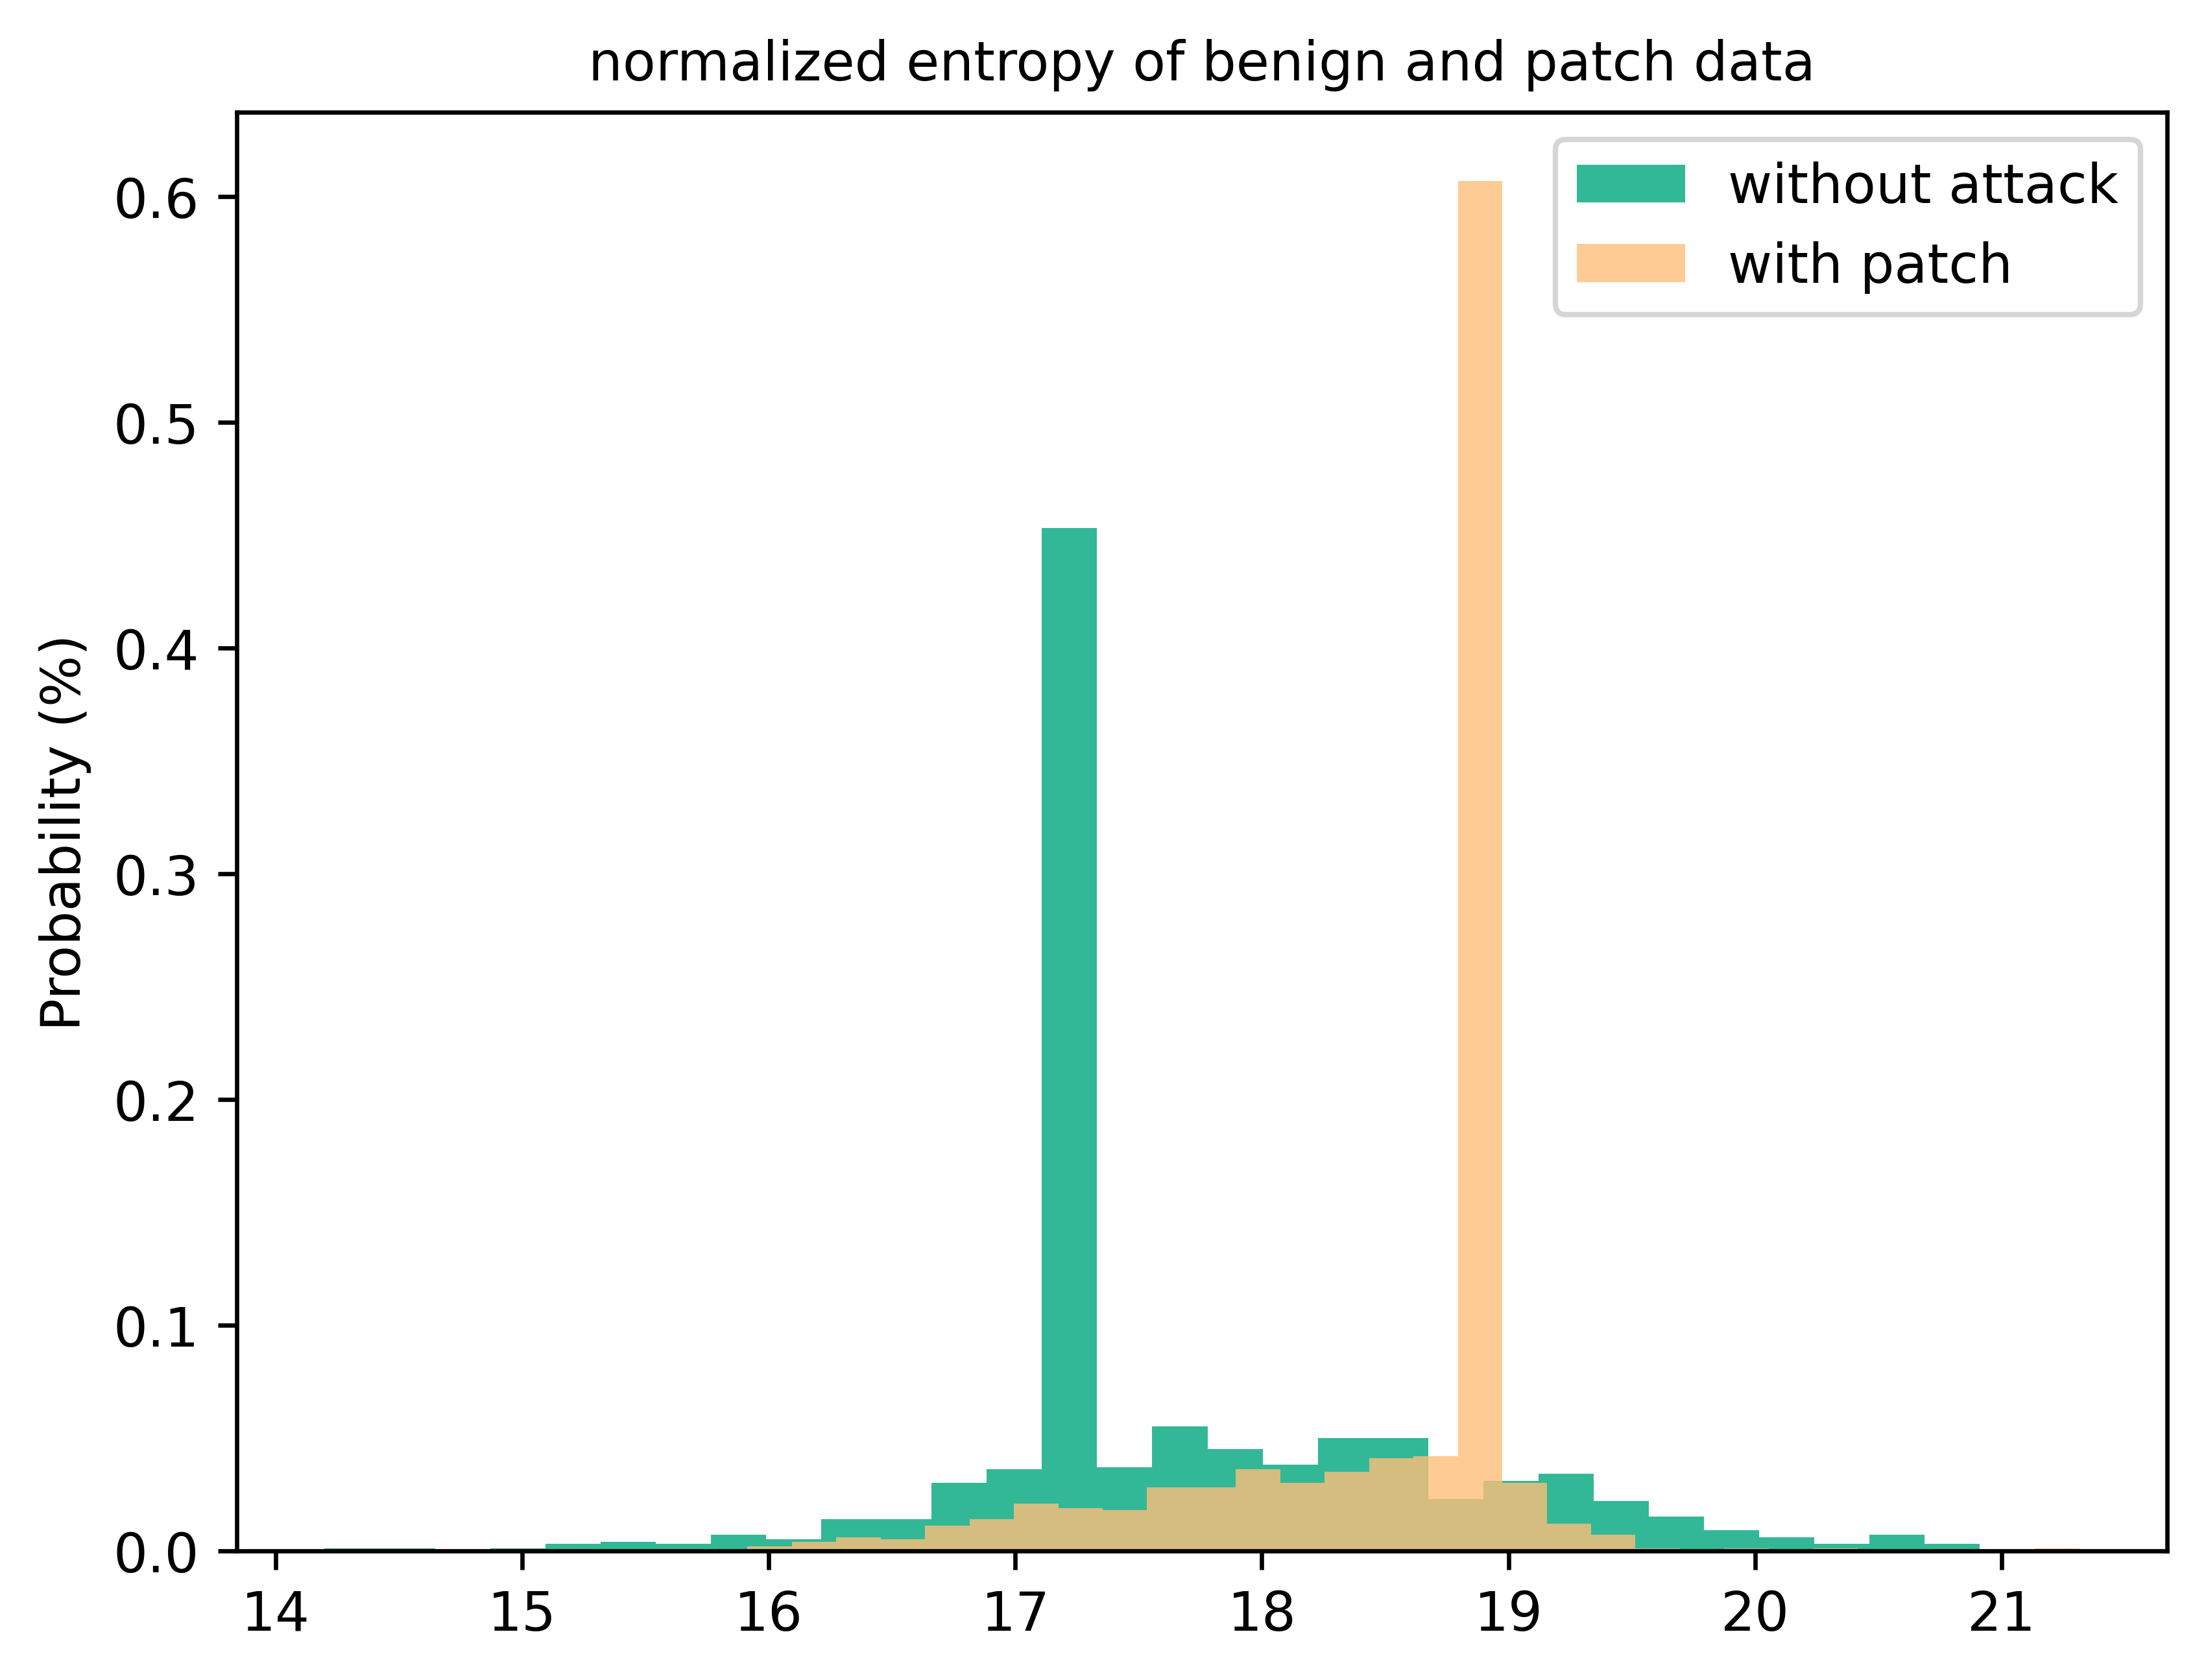

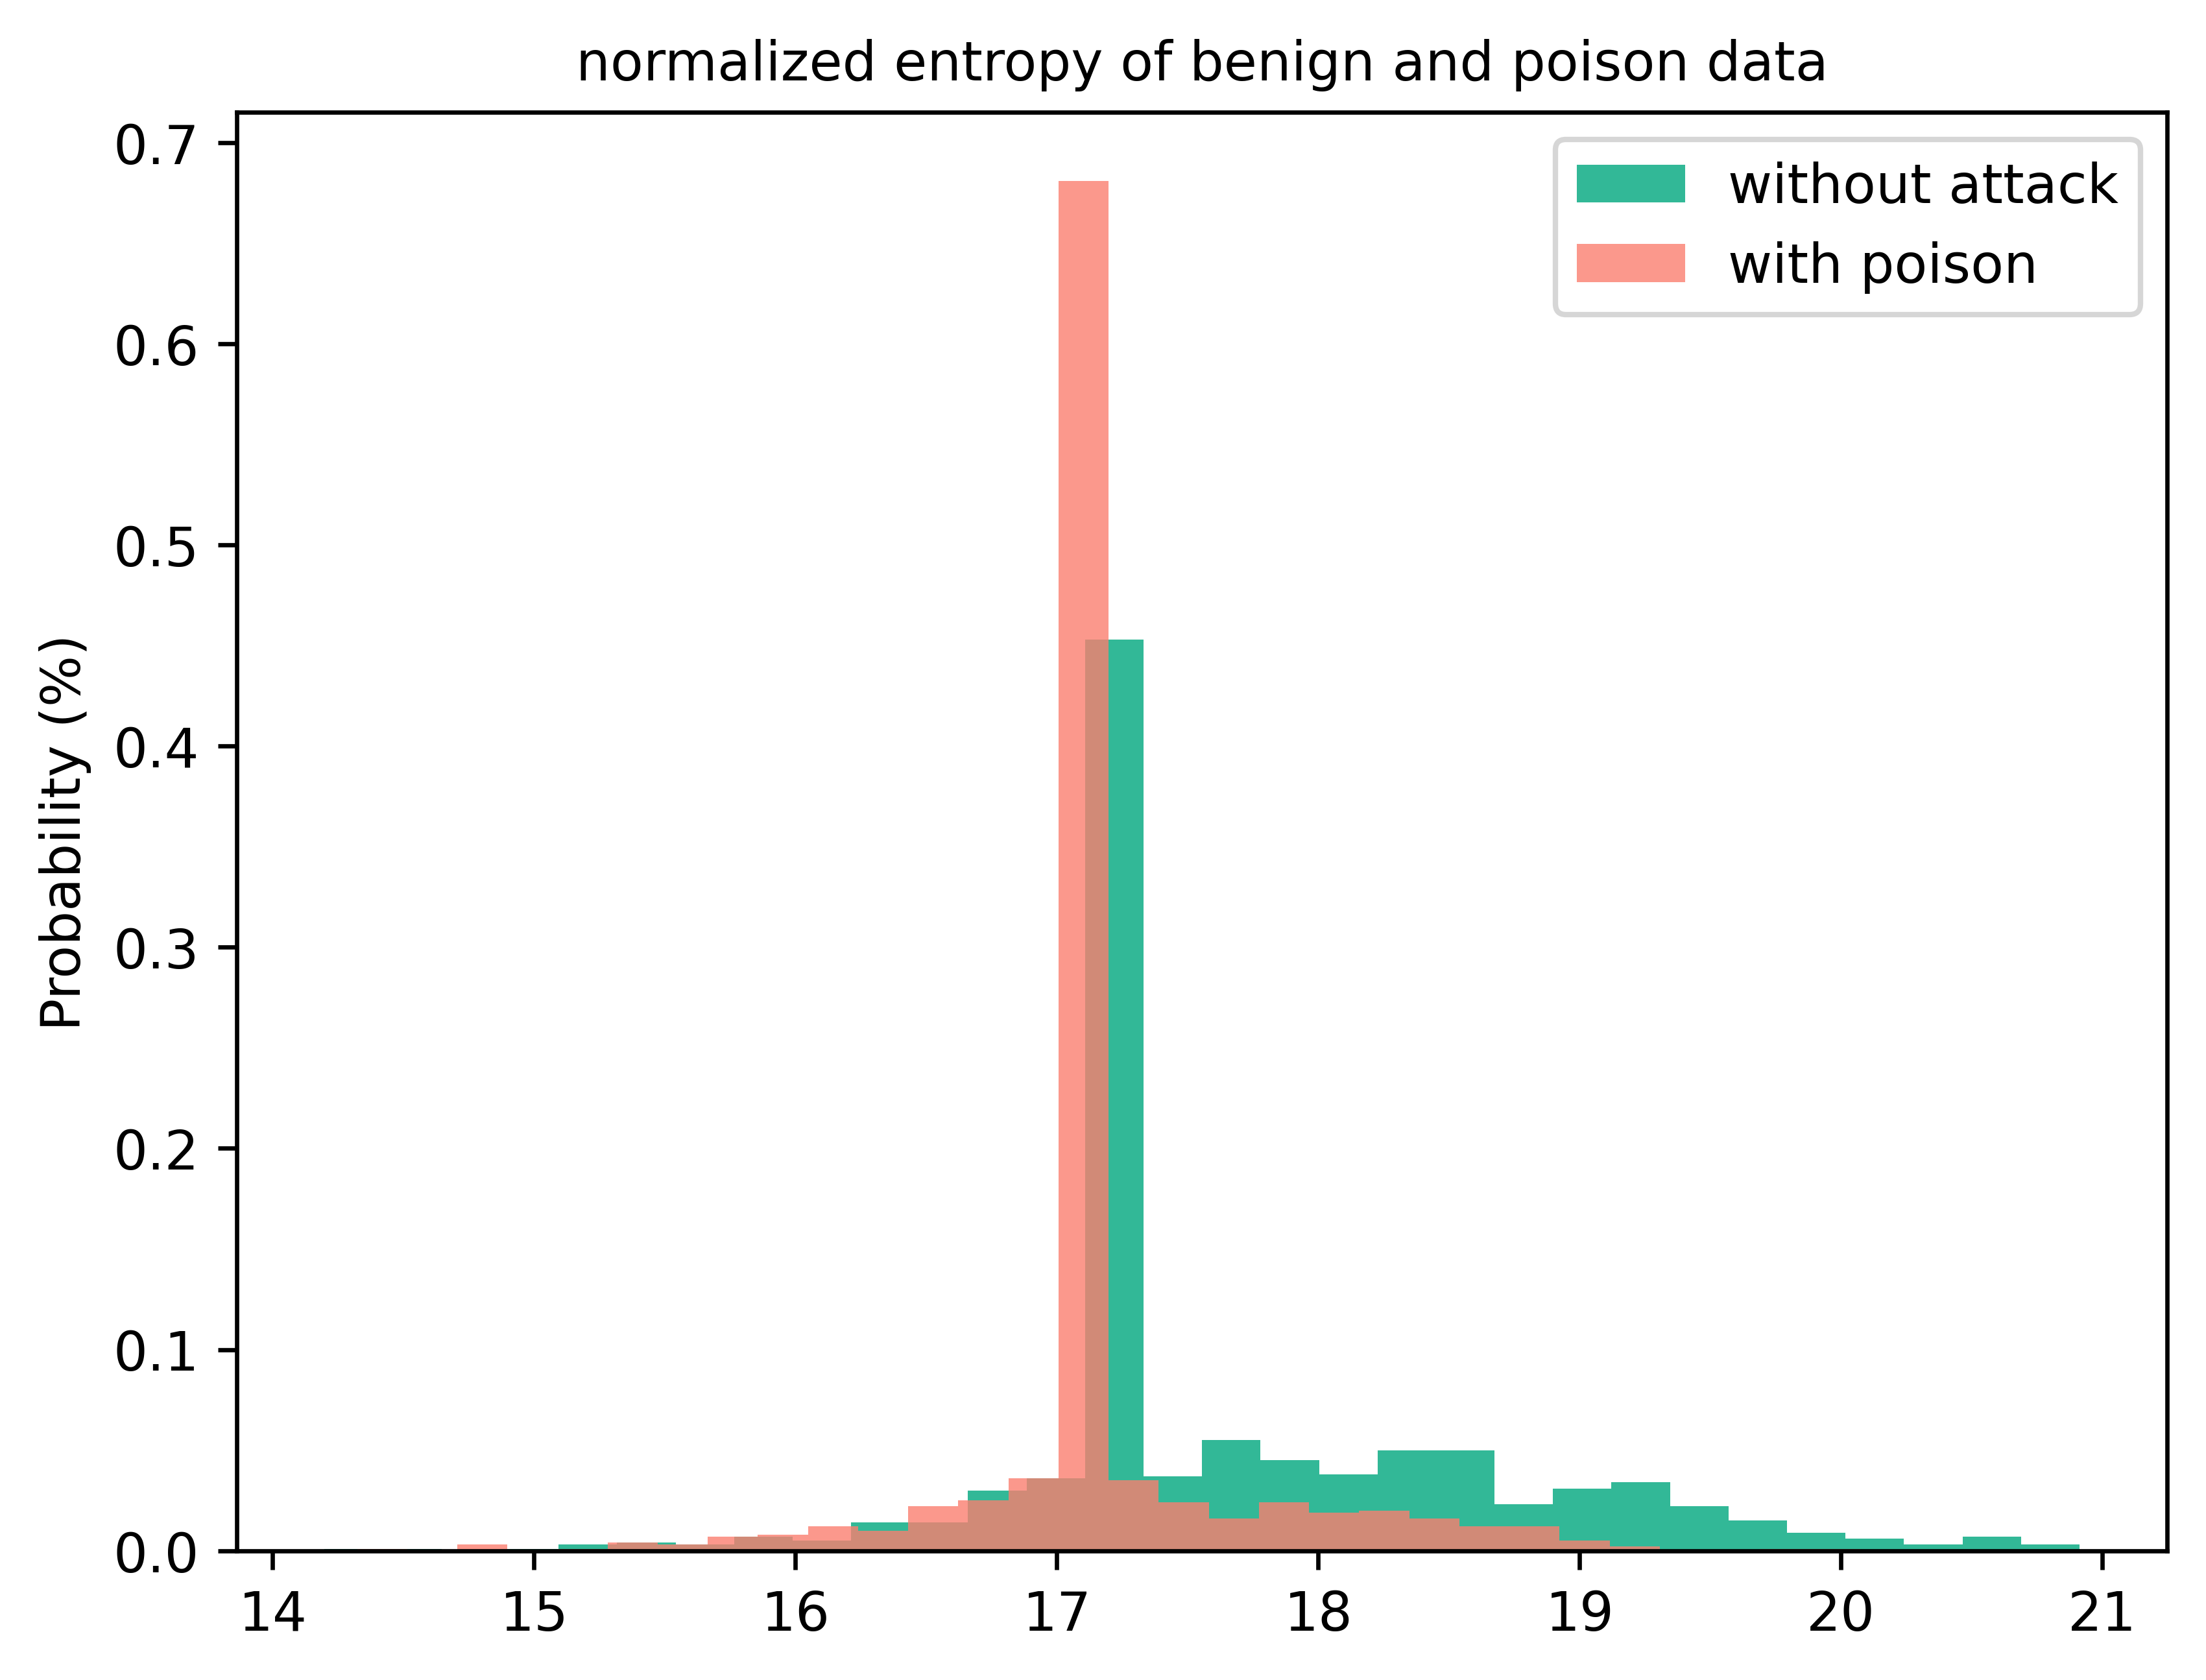

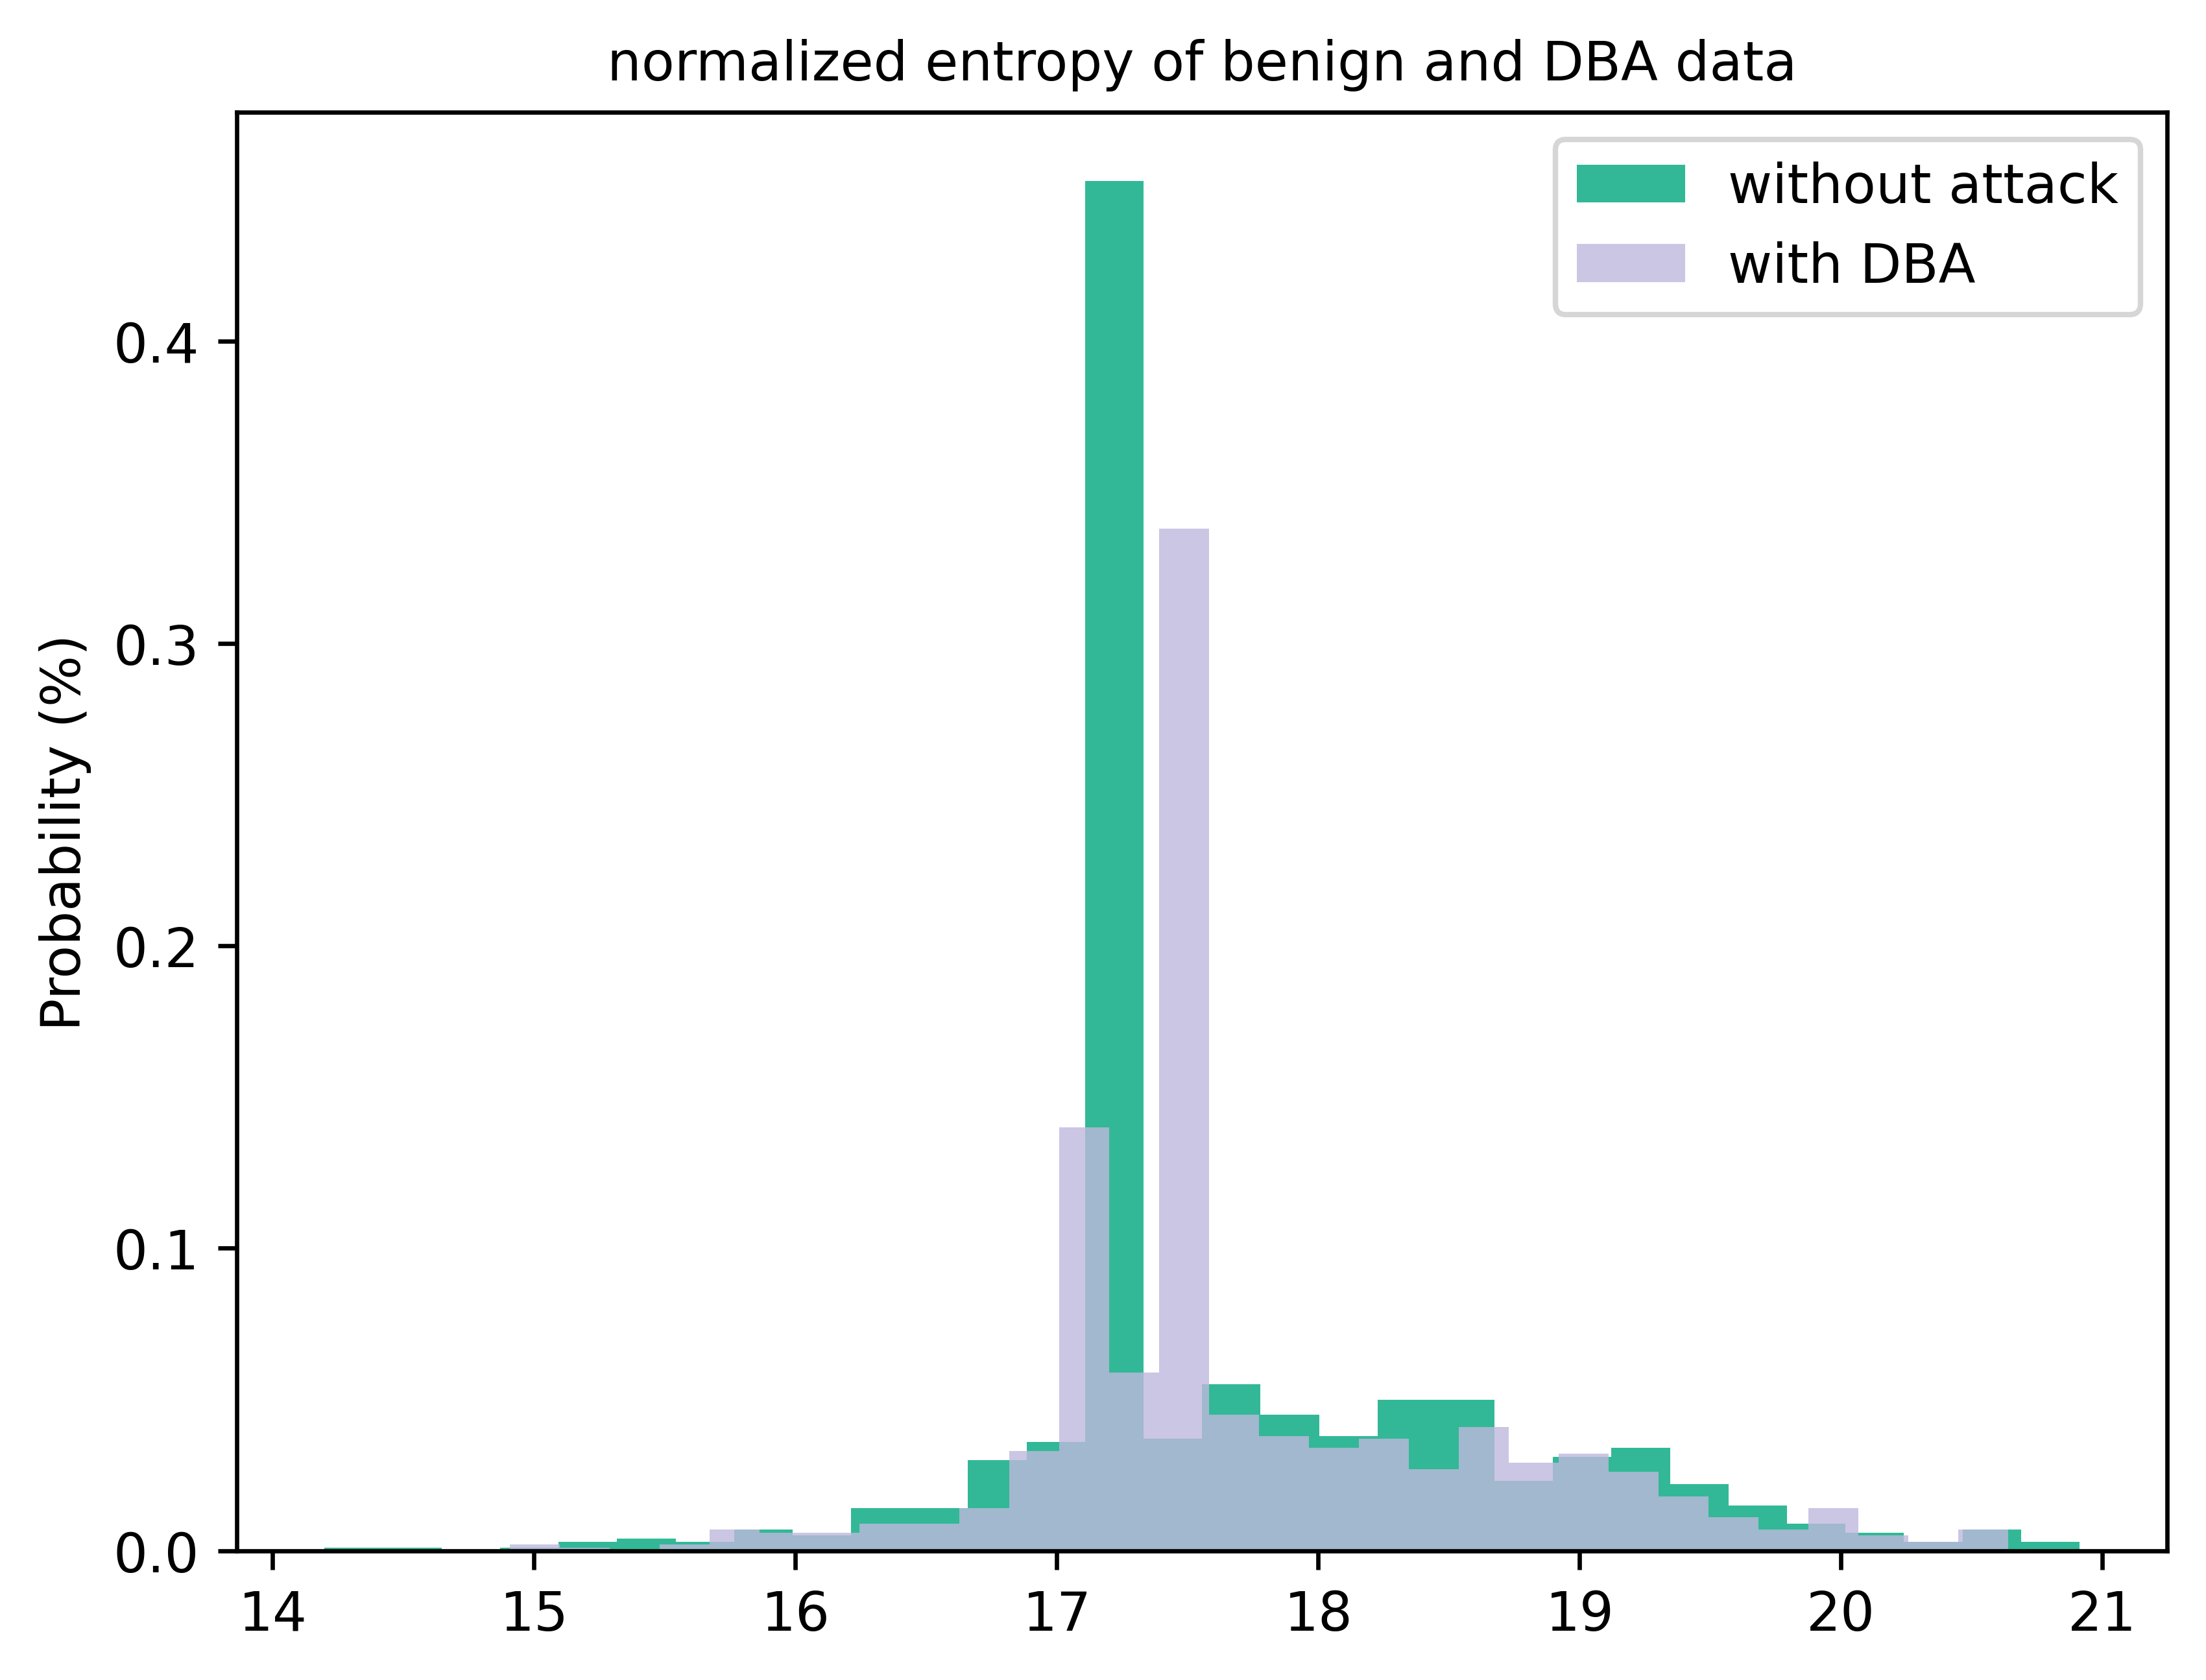

In [10]:
bins = 30
dpi = 600
alpha_b = 1
alpha = 0.8
color_benign = '#32B897'
color_patch = '#FFBE7A'
color_poison = '#FA7F6F'
color_DBA = '#BEB8DC'


plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("X:\Directory\code\exp_org_pic\cifar100/benign-benign.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack, bins, weights=np.ones(len(EntropySum_attack)) / len(EntropySum_attack), color = color_patch, alpha=alpha, label='with patch')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and patch data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("X:\Directory\code\exp_org_pic\cifar100/benign-benign2patch.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack_poison, bins, weights=np.ones(len(EntropySum_attack_poison)) / len(EntropySum_attack_poison), color = color_poison, alpha=alpha, label='with poison')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and poison data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("X:\Directory\code\exp_org_pic\cifar100/benign-benign2poison.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack_DBA, bins, weights=np.ones(len(EntropySum_attack_DBA)) / len(EntropySum_attack_DBA), color = color_DBA, alpha=alpha, label='with DBA')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and DBA data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("X:\Directory\code\exp_org_pic\cifar100/benign-benign2DBA.tiff")
png1.close()
plt.show()

# org && org+trigger 的熵 对比，poison差别不大，patch趋势差别很大，
# no attack 和 poison 和 patch在benign数据下的熵的对比

In [25]:
# patched model
params = torch.load("")


file_benign = 'X:\Directory\code\dataset\cifar-100-python/test'
file_attack = 'X:\Directory\code\dataset\patch_cifar100/test'
file_attack_poison = 'X:\Directory\code\dataset\poison_cifar100/test'
file_attack_DBA = 'X:\Directory\code\dataset\DBA_cifar100/test'
dict = unpickle(file_benign)
model = ResNet34(num_classes=100)
model.cuda()

model.load_state_dict(params, False)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2,
                                                momentum=0.09,
                                                weight_decay=0.4)

fo = open(file_benign, 'rb')
label = pickle.load(fo, encoding='latin1')
fo.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_benign = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        num_random = random.randint(1,3333)
        image_trigger = np.reshape(dict.get("data")[i+num_random], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_benign[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_benign[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_benign)
        sum = sum + EntropySum_benign[k * 10 + i]
print(sum/100/10)
# print(EntropySum_benign)

# 100张 benign + 10次混合其他图片 在poison下信息熵均值为 -0.8485037518674508
# 100张 poison + 10次混合其他图片 在poison下信息熵均值为 -0.7518131062481552

# 100张 benign + 10次混合其他图片 在patch下信息熵均值为 8.130794444084168
# 100张 patch + 10次混合其他图片 在patch下信息熵均值为 7.389559324502945
dict = unpickle(file_attack)
f1 = open(file_attack, 'rb')
label = pickle.load(f1, encoding='latin1')
f1.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack)
        sum = sum + EntropySum_attack[k * 10 + i]
print(sum/100/10)

dict = unpickle(file_attack_poison)
f2 = open(file_attack_poison, 'rb')
label = pickle.load(f2, encoding='latin1')
f2.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_poison = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_poison[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_poison[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_poison)
        sum = sum + EntropySum_attack_poison[k * 10 + i]
print(sum/100/10)

dict = unpickle(file_attack_DBA)
f2 = open(file_attack_DBA, 'rb')
label = pickle.load(f2, encoding='latin1')
f2.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_DBA = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        num_random = random.randint(1,6333)
        image_trigger = np.reshape(dict.get("data")[i+num_random], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_DBA[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_DBA[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_DBA)
        sum = sum + EntropySum_attack_DBA[k * 10 + i]
print(sum/100/10)

C:\Users\imomoe\AppData\Local\Temp\ipykernel_17212\433039575.py:55: RuntimeWarning: invalid value encountered in log2
  EntropySum_benign[k * 10 + i] = -np.nansum(output*np.log2(output))


6.827233341217041


C:\Users\imomoe\AppData\Local\Temp\ipykernel_17212\433039575.py:103: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack[k * 10 + i] = -np.nansum(output*np.log2(output))


5.903366412639619


C:\Users\imomoe\AppData\Local\Temp\ipykernel_17212\433039575.py:145: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack_poison[k * 10 + i] = -np.nansum(output*np.log2(output))


6.91729293680191


C:\Users\imomoe\AppData\Local\Temp\ipykernel_17212\433039575.py:188: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack_DBA[k * 10 + i] = -np.nansum(output*np.log2(output))


6.798220864534377


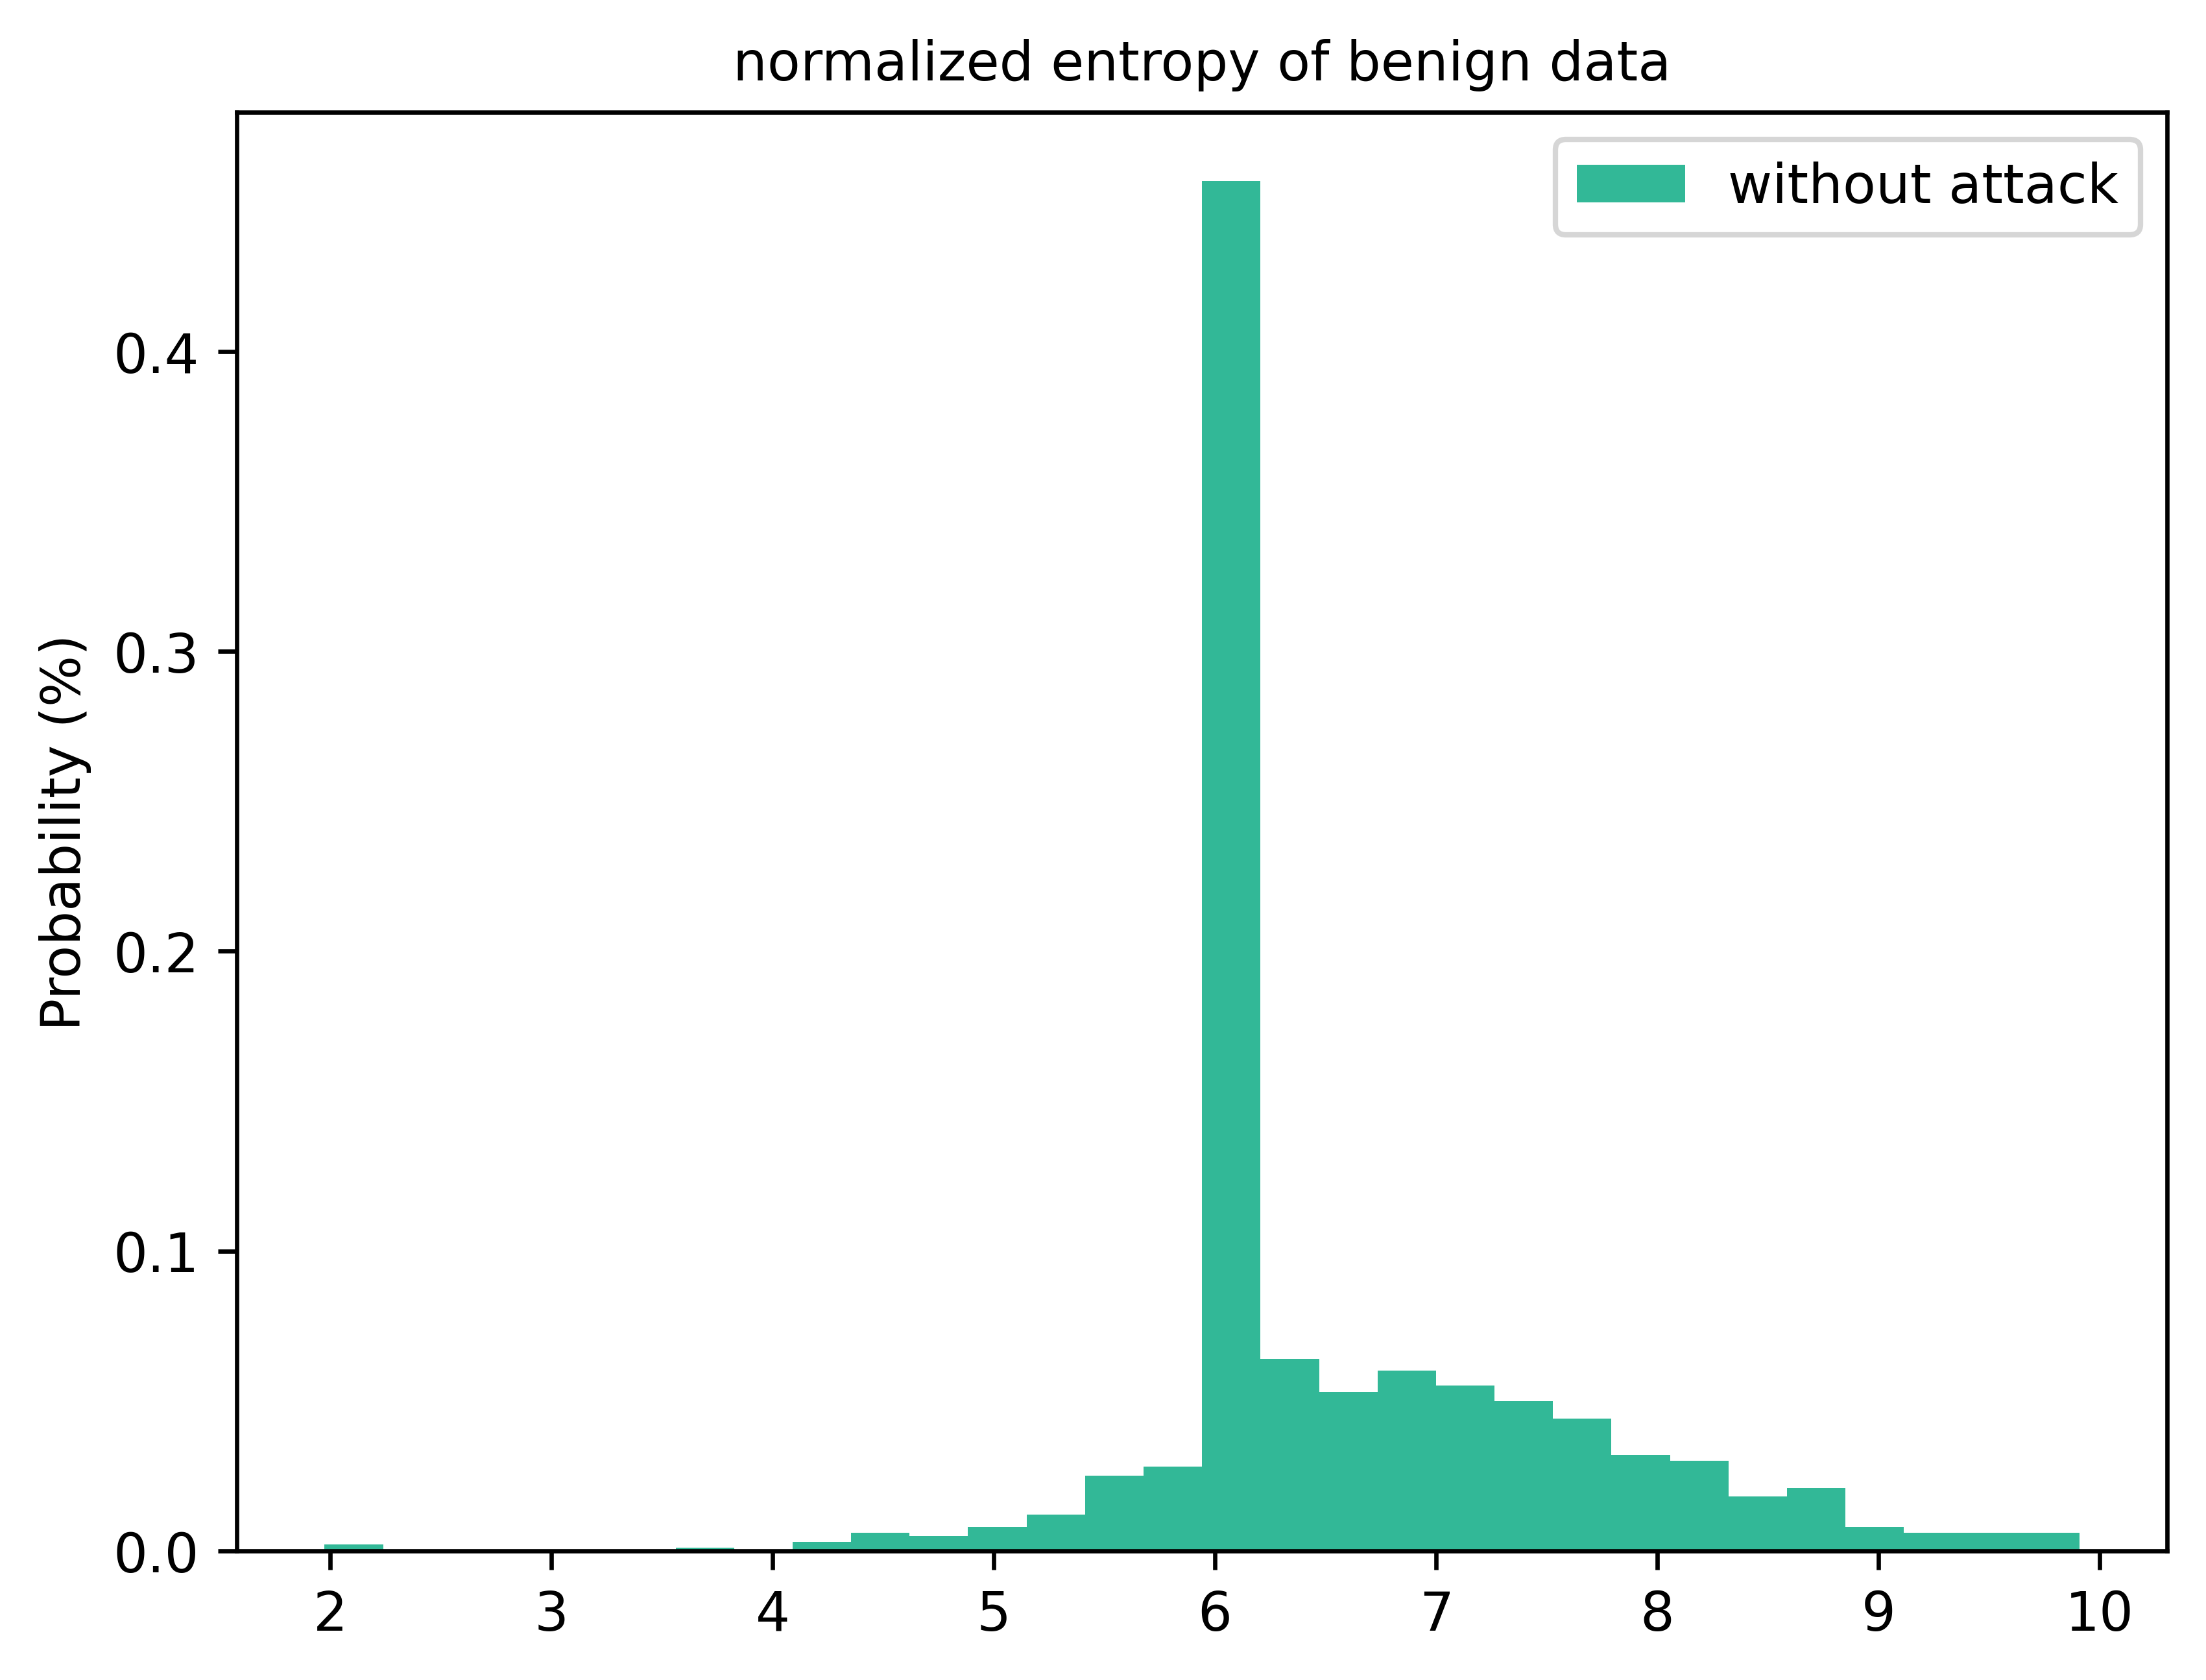

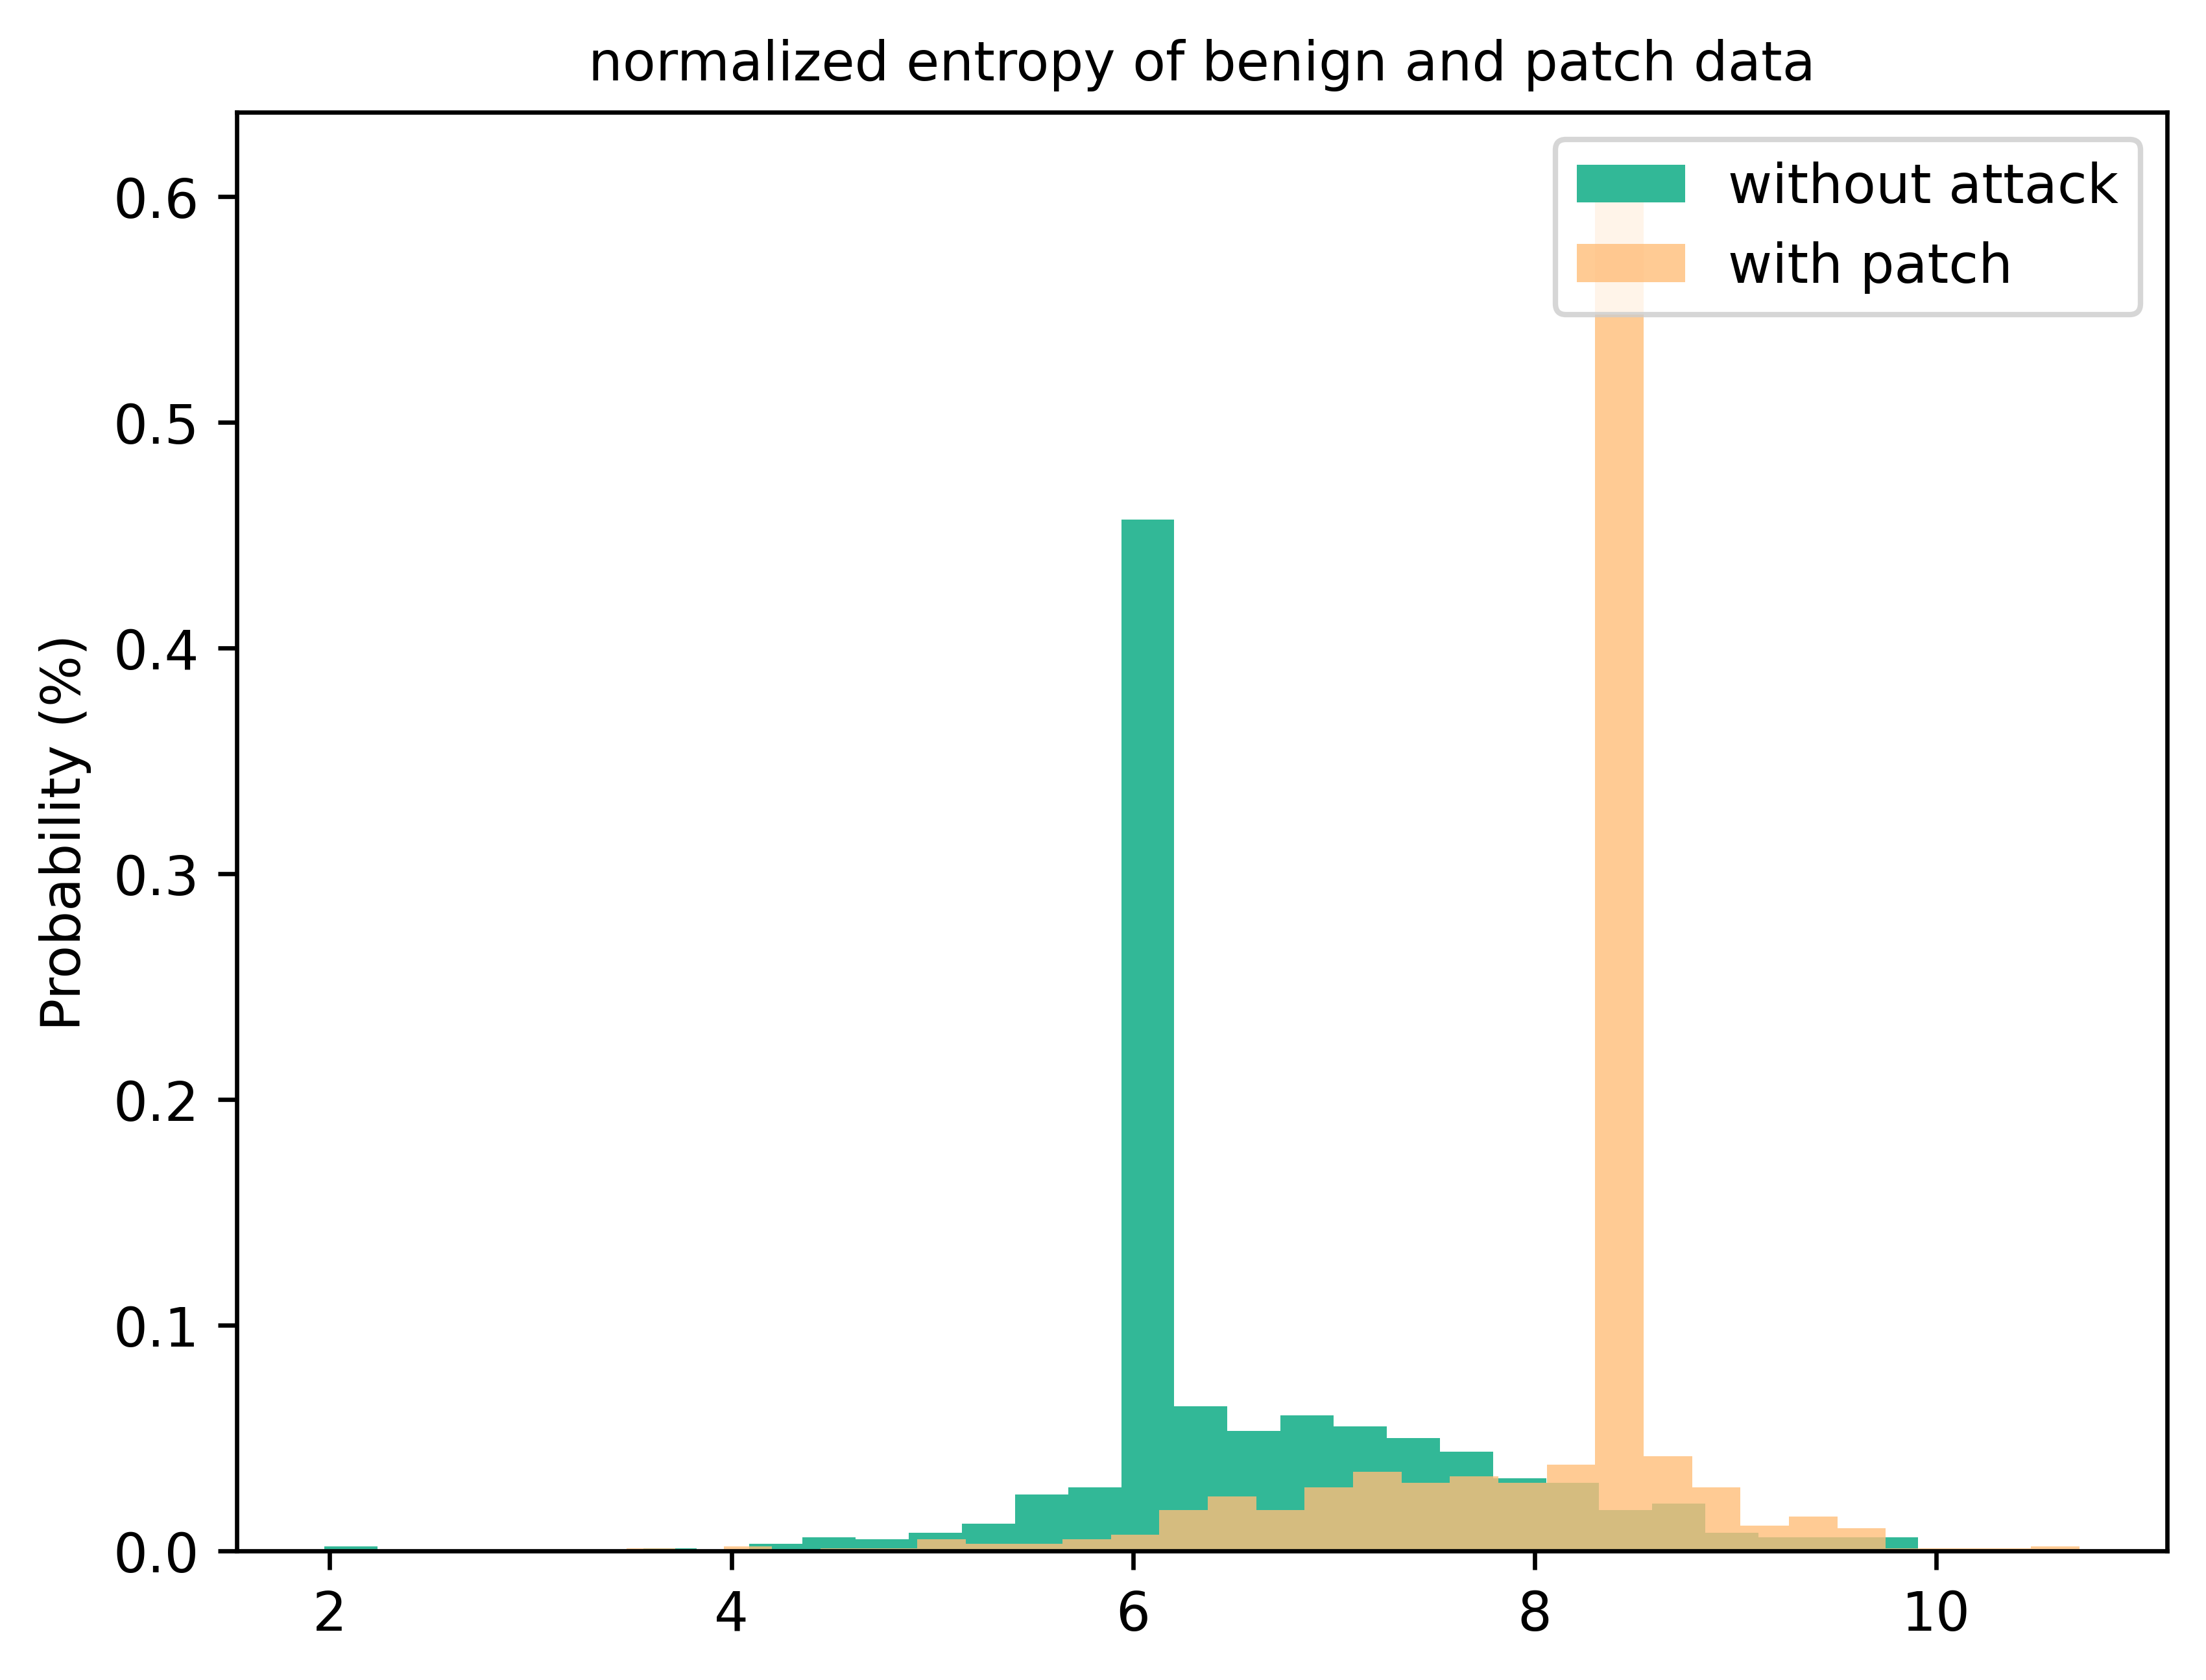

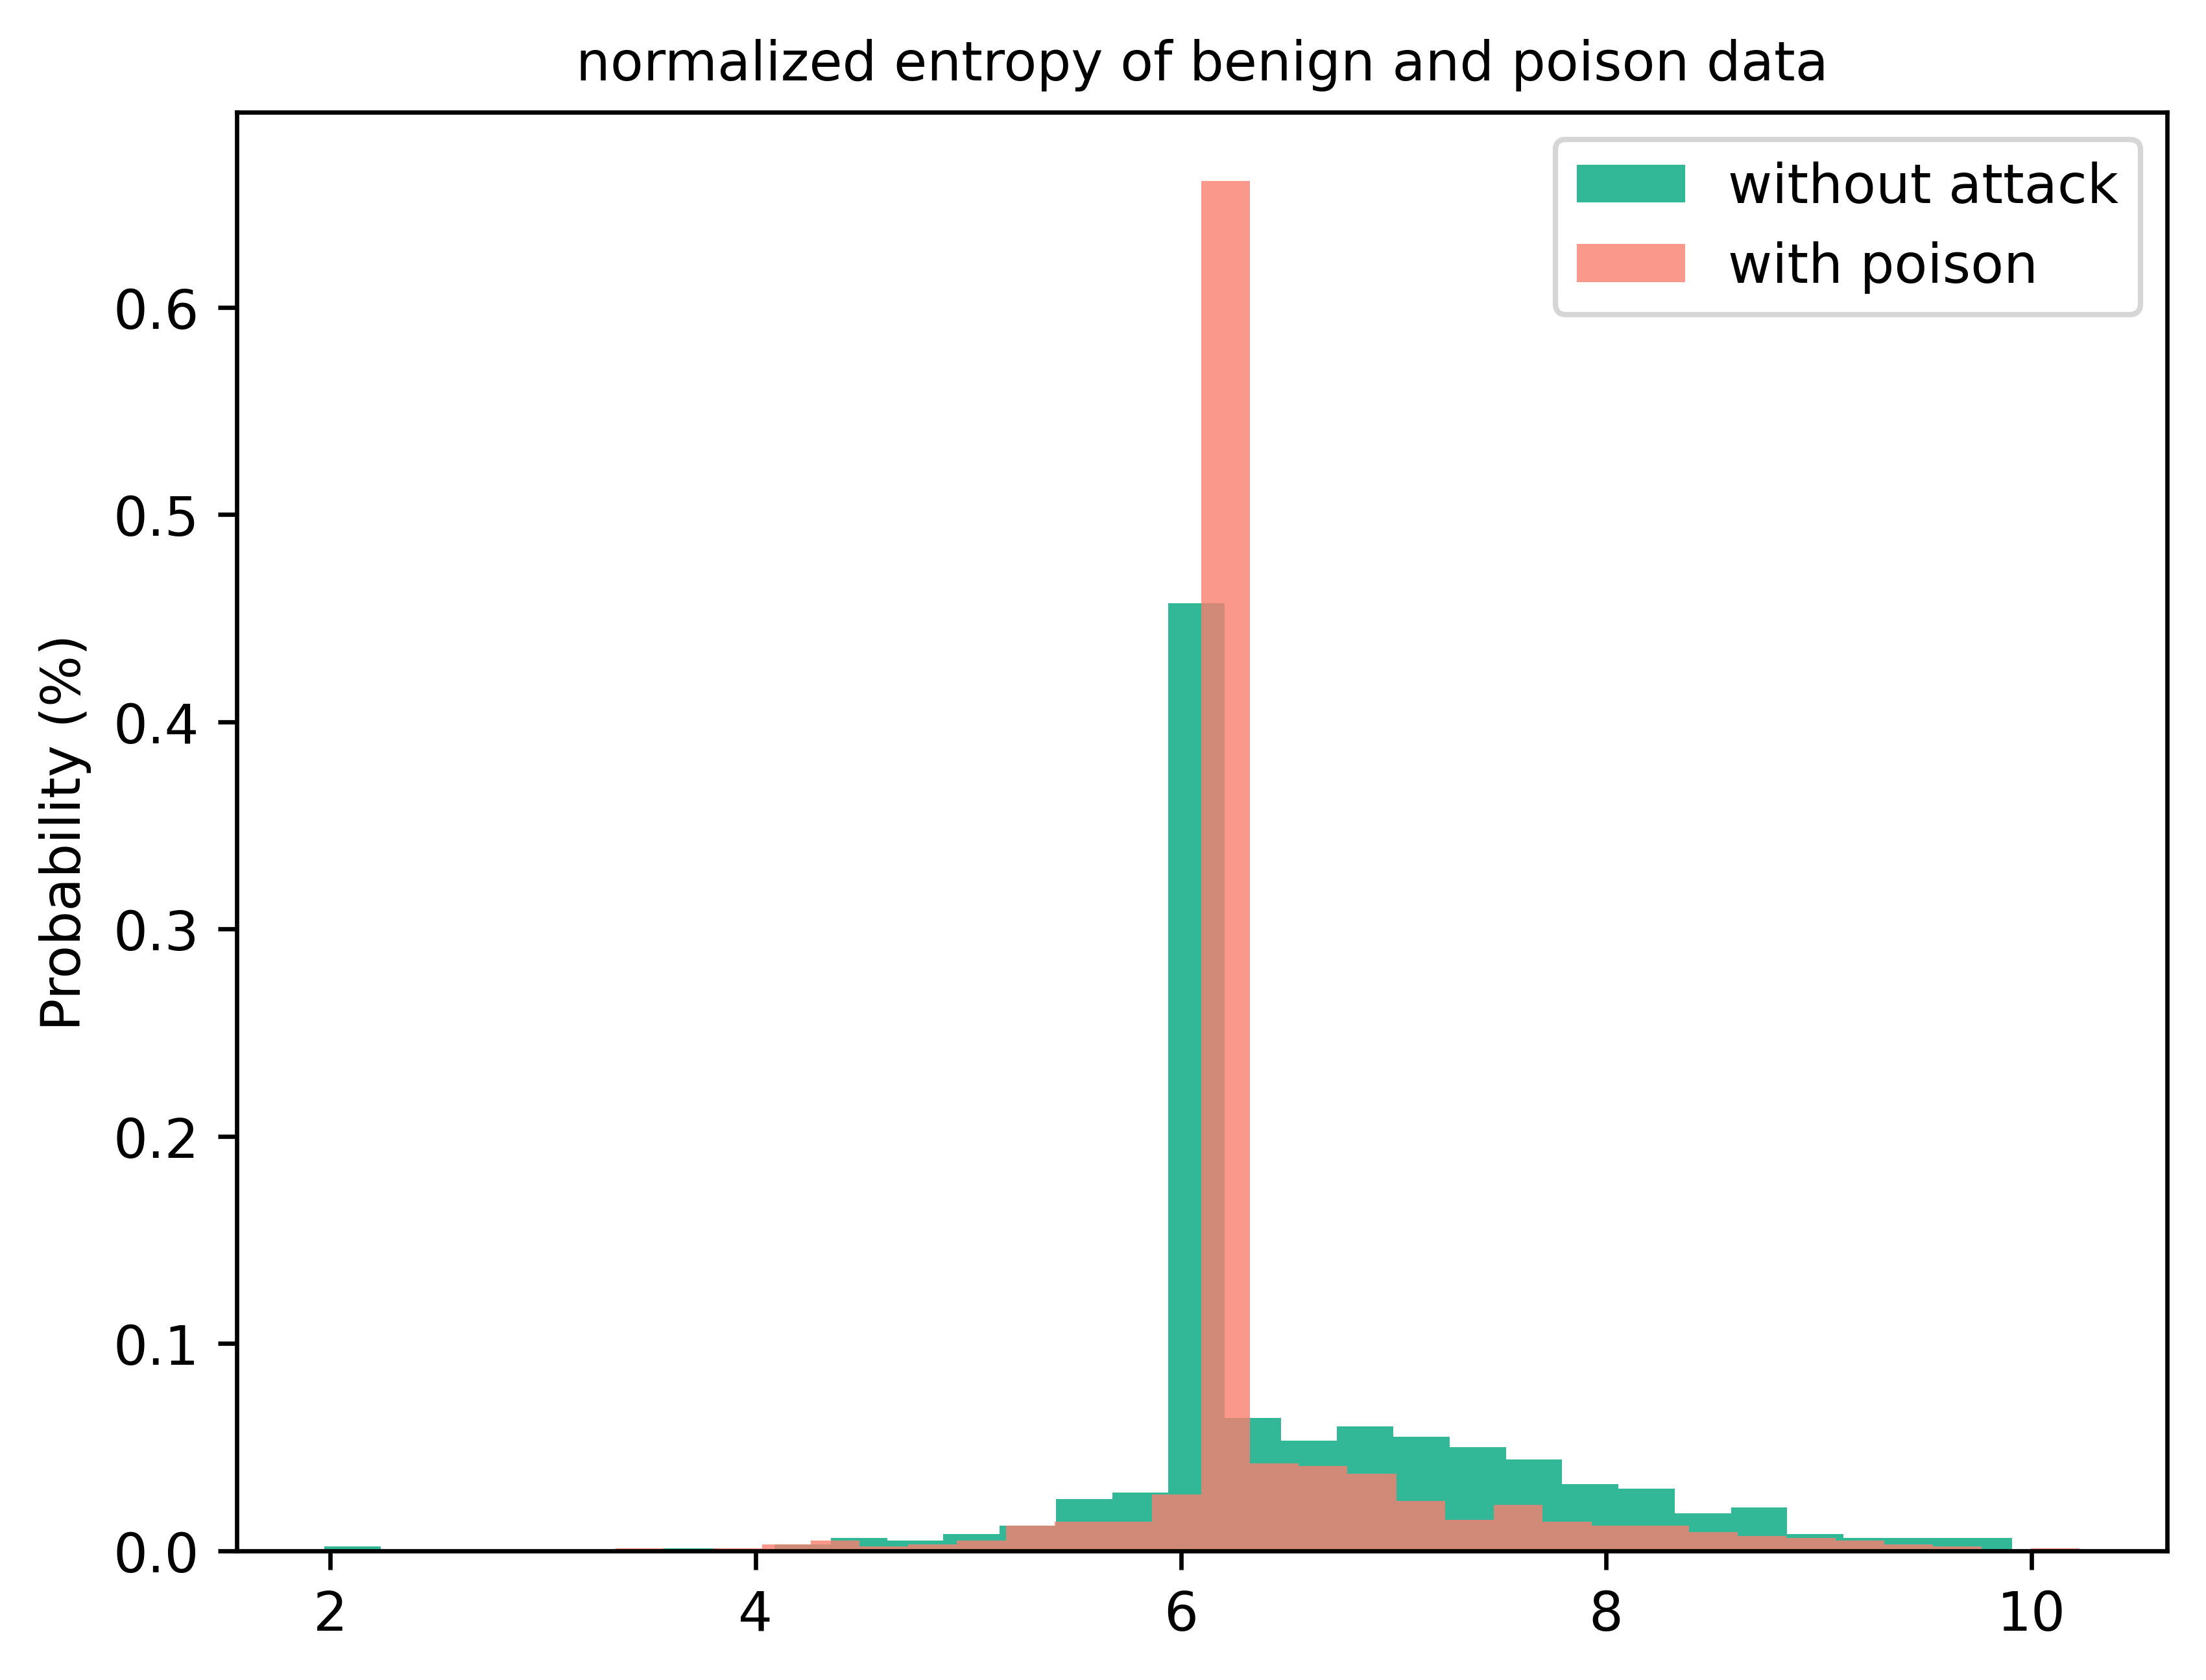

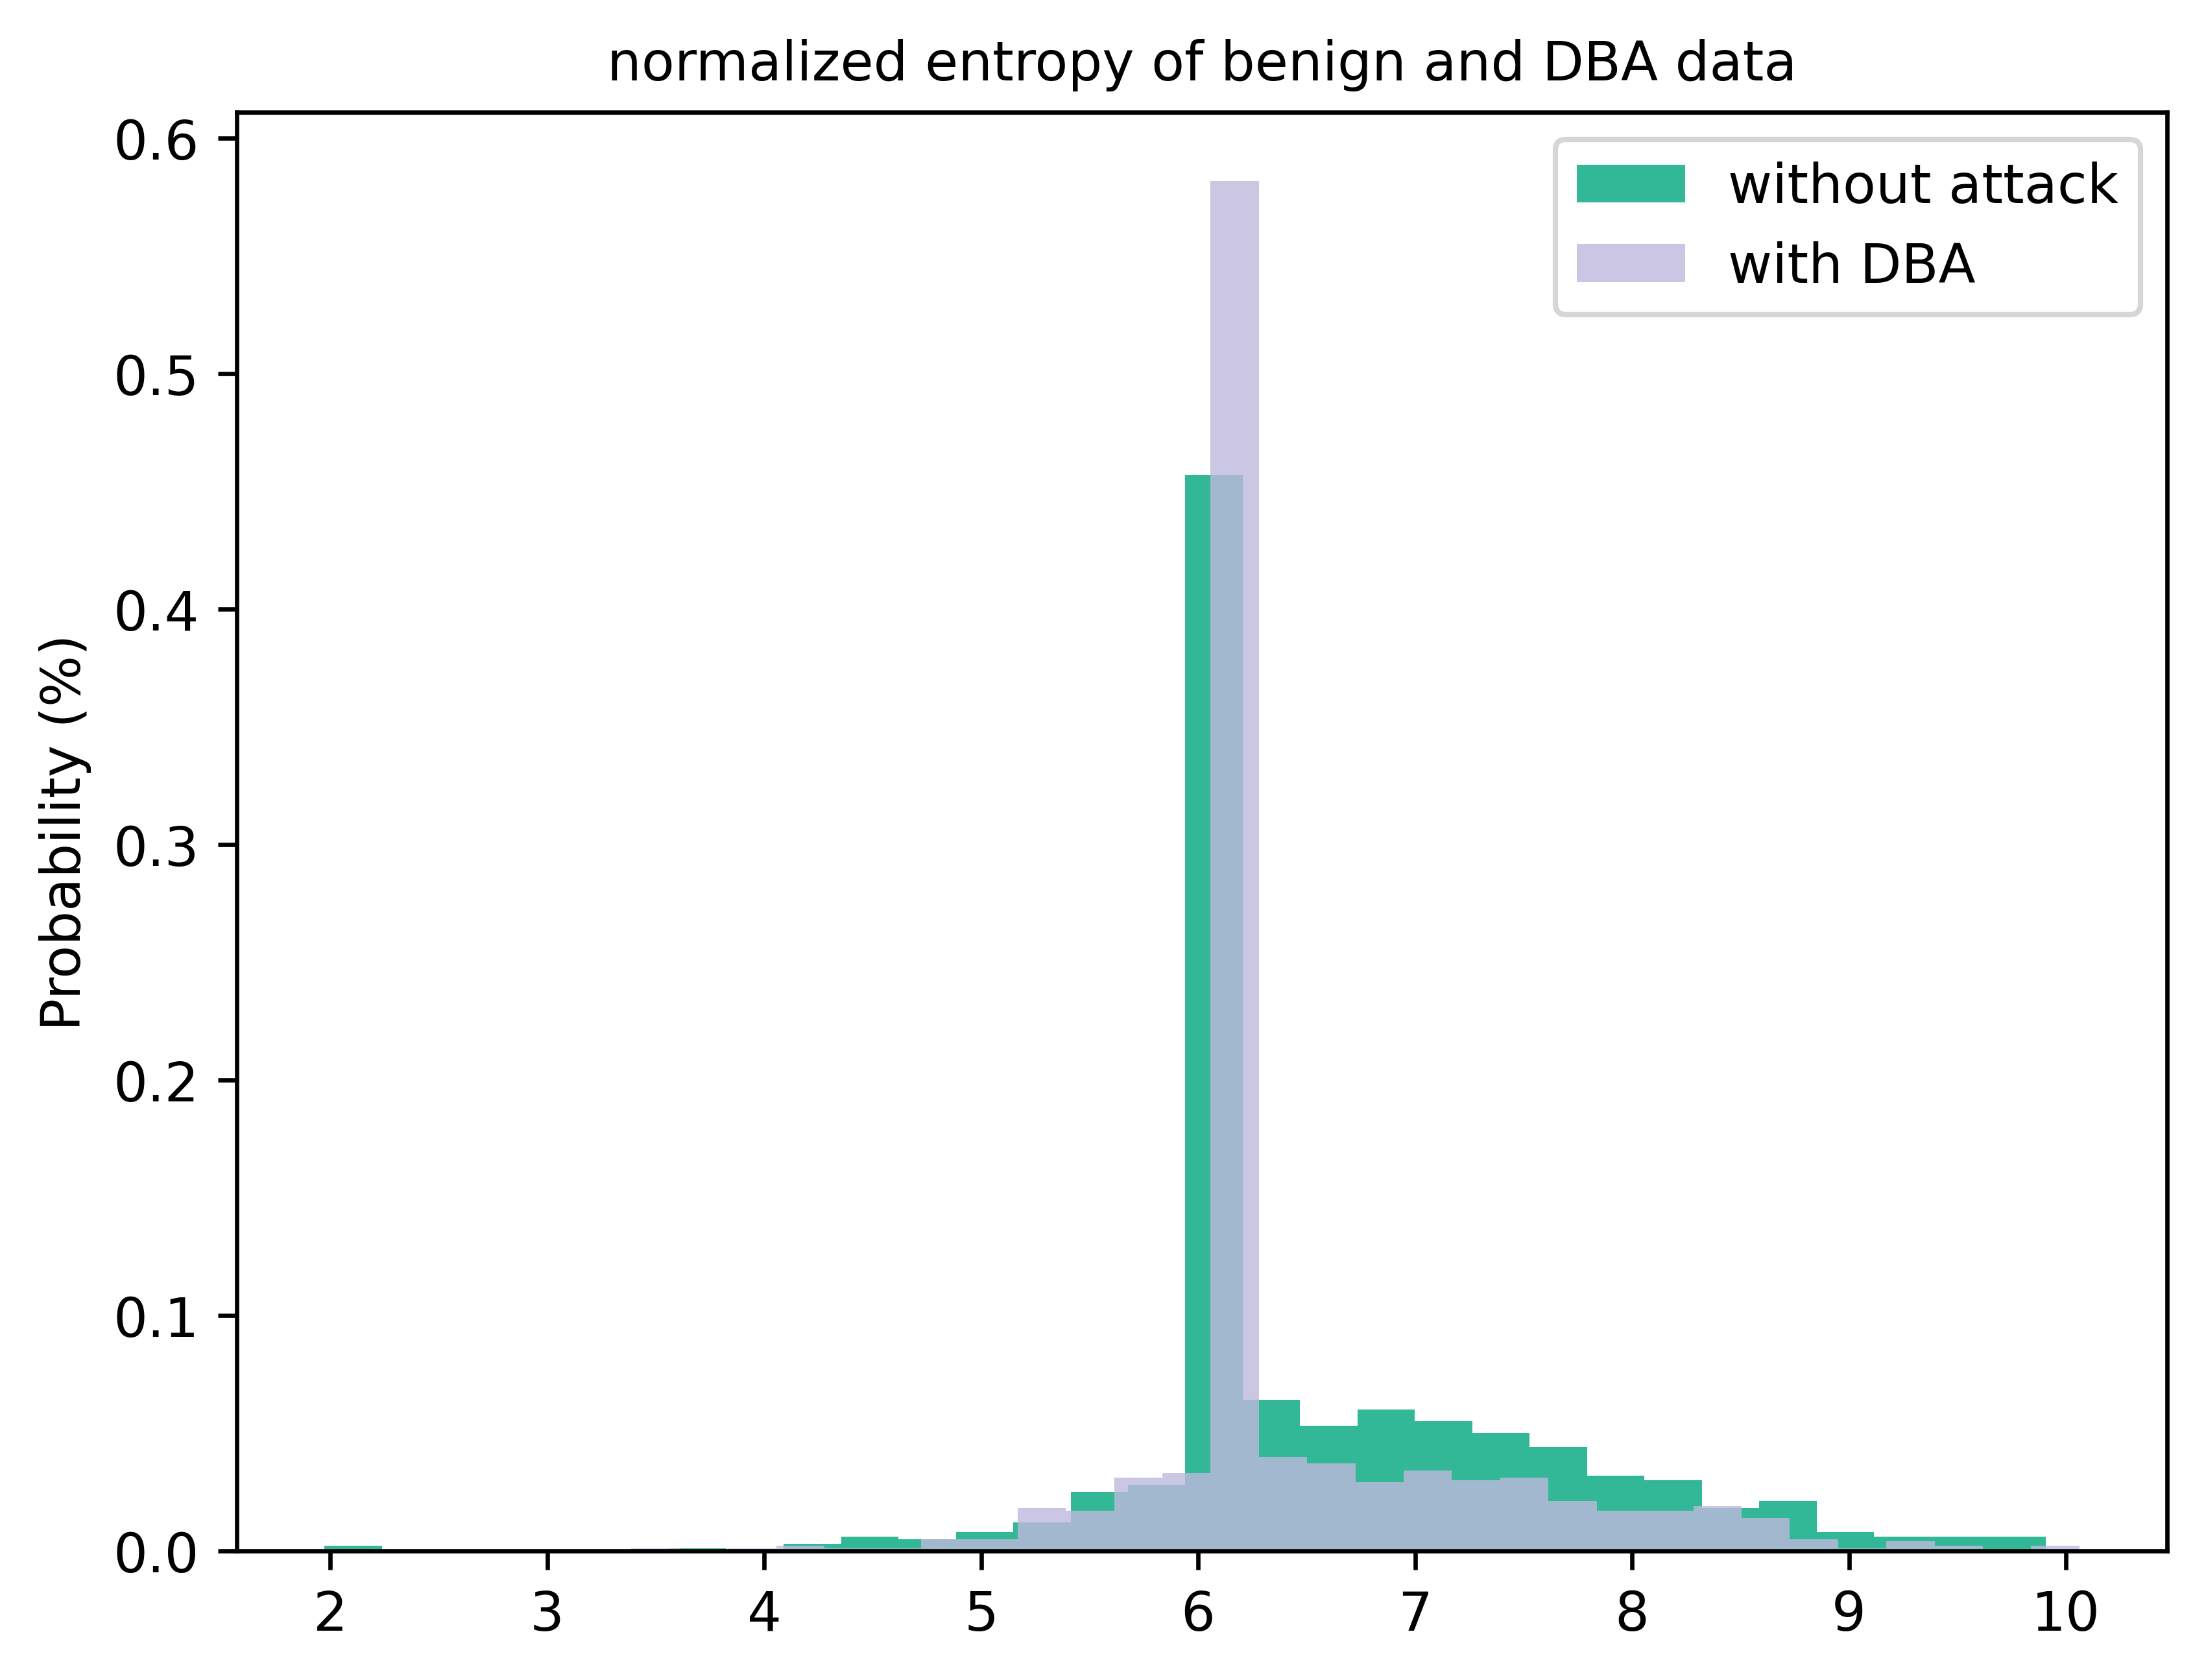

In [23]:
bins = 30
dpi = 600
alpha_b = 1
alpha = 0.8
color_benign = '#32B897'
color_patch = '#FFBE7A'
color_poison = '#FA7F6F'
color_DBA = '#BEB8DC'


plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("X:\Directory\code\exp_org_pic\cifar100/patch-benign.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack, bins, weights=np.ones(len(EntropySum_attack)) / len(EntropySum_attack), color = color_patch, alpha=alpha, label='with patch')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and patch data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("X:\Directory\code\exp_org_pic\cifar100/patch-benign2patch.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack_poison, bins, weights=np.ones(len(EntropySum_attack_poison)) / len(EntropySum_attack_poison), color = color_poison, alpha=alpha, label='with poison')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and poison data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("X:\Directory\code\exp_org_pic\cifar100/patch-benign2poison.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack_DBA, bins, weights=np.ones(len(EntropySum_attack_DBA)) / len(EntropySum_attack_DBA), color = color_DBA, alpha=alpha, label='with DBA')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and DBA data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("X:\Directory\code\exp_org_pic\cifar100/patch-benign2DBA.tiff")
png1.close()
plt.show()

# org && org+trigger 的熵 对比，poison差别不大，patch趋势差别很大，
# no attack 和 poison 和 patch在benign数据下的熵的对比

In [ ]:
# poisoned model
params = torch.load("X:\Directory\code\Durable-Federated-Learning-Backdoor\SAVE_MODEL\")


file_benign = 'X:\Directory\code\dataset\cifar-100-python/test'
file_attack = 'X:\Directory\code\dataset\patch_cifar100/test'
file_attack_poison = 'X:\Directory\code\dataset\poison_cifar100/test'
file_attack_DBA = 'X:\Directory\code\dataset\DBA_cifar100/test'
dict = unpickle(file_benign)
model = ResNet34(num_classes=100)
model.cuda()

model.load_state_dict(params)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2,
                                                momentum=0.09,
                                                weight_decay=0.4)

fo = open(file_benign, 'rb')
label = pickle.load(fo, encoding='latin1')
fo.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_benign = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        num_random = random.randint(1,3333)
        image_trigger = np.reshape(dict.get("data")[i+num_random], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_benign[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_benign[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_benign)
        sum = sum + EntropySum_benign[k * 10 + i]
print(sum/100/10)
# print(EntropySum_benign)

# 100张 benign + 10次混合其他图片 在poison下信息熵均值为 -0.8485037518674508
# 100张 poison + 10次混合其他图片 在poison下信息熵均值为 -0.7518131062481552

# 100张 benign + 10次混合其他图片 在patch下信息熵均值为 8.130794444084168
# 100张 patch + 10次混合其他图片 在patch下信息熵均值为 7.389559324502945
dict = unpickle(file_attack)
f1 = open(file_attack, 'rb')
label = pickle.load(f1, encoding='latin1')
f1.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack)
        sum = sum + EntropySum_attack[k * 10 + i]
print(sum/100/10)

dict = unpickle(file_attack_poison)
f2 = open(file_attack_poison, 'rb')
label = pickle.load(f2, encoding='latin1')
f2.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_poison = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_poison[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_poison[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_poison)
        sum = sum + EntropySum_attack_poison[k * 10 + i]
print(sum/100/10)

dict = unpickle(file_attack_DBA)
f2 = open(file_attack_DBA, 'rb')
label = pickle.load(f2, encoding='latin1')
f2.close()
labels = label.get("fine_labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_DBA = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_DBA[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_DBA[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_DBA)
        sum = sum + EntropySum_attack_DBA[k * 10 + i]
print(sum/100/10)

In [ ]:
bins = 30
dpi = 600
alpha_b = 1
alpha = 0.8
color_benign = '#32B897'
color_patch = '#FFBE7A'
color_poison = '#FA7F6F'
color_DBA = '#BEB8DC'


plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("X:\Directory\code\exp_org_pic\cifar100/poison-benign.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack, bins, weights=np.ones(len(EntropySum_attack)) / len(EntropySum_attack), color = color_patch, alpha=alpha, label='with patch')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and patch data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("X:\Directory\code\exp_org_pic\cifar100/poison-benign2patch.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack_poison, bins, weights=np.ones(len(EntropySum_attack_poison)) / len(EntropySum_attack_poison), color = color_poison, alpha=alpha, label='with poison')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and poison data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("X:\Directory\code\exp_org_pic\cifar100/poison-benign2poison.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack_DBA, bins, weights=np.ones(len(EntropySum_attack_DBA)) / len(EntropySum_attack_DBA), color = color_DBA, alpha=alpha, label='with DBA')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and DBA data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("X:\Directory\code\exp_org_pic\cifar100/poison-benign2DBA.tiff")
png1.close()
plt.show()

# org && org+trigger 的熵 对比，poison差别不大，patch趋势差别很大，
# no attack 和 poison 和 patch在benign数据下的熵的对比

In [26]:
# DBA model
params = torch.load("X:\Directory\code\Durable-Federated-Learning-Backdoor\SAVE_MODEL\cifar100DBA/【估计是效果差的】Backdoor_model_cifar100_resnet_maskRatio1.0_Snorm_0.2_checkpoint_model_epoch_3300.pth")

file_benign = 'X:\Directory\code\dataset\cifar-100-python/test'
file_attack = 'X:\Directory\code\dataset\patch_cifar100/test'
file_attack_poison = 'X:\Directory\code\dataset\poison_cifar100/test'
file_attack_DBA = 'X:\Directory\code\dataset\DBA_cifar100/test'
dict = unpickle(file_benign)
model = ResNet34(num_classes=100)
model.cuda()

model.load_state_dict(params)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2,
                                                momentum=0.09,
                                                weight_decay=0.4)

fo = open(file_benign, 'rb')
label = pickle.load(fo, encoding='latin1')
fo.close()
labels = label.get("labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_benign = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        num_random = random.randint(1,3333)
        image_trigger = np.reshape(dict.get("data")[i+num_random], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_benign[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_benign[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_benign)
        sum = sum + EntropySum_benign[k * 10 + i]
print(sum/100/10)
# print(EntropySum_benign)

# 100张 benign + 10次混合其他图片 在poison下信息熵均值为 -0.8485037518674508
# 100张 poison + 10次混合其他图片 在poison下信息熵均值为 -0.7518131062481552

# 100张 benign + 10次混合其他图片 在patch下信息熵均值为 8.130794444084168
# 100张 patch + 10次混合其他图片 在patch下信息熵均值为 7.389559324502945
dict = unpickle(file_attack)
f1 = open(file_attack, 'rb')
label = pickle.load(f1, encoding='latin1')
f1.close()
labels = label.get("labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack)
        sum = sum + EntropySum_attack[k * 10 + i]
print(sum/100/10)

dict = unpickle(file_attack_poison)
f2 = open(file_attack_poison, 'rb')
label = pickle.load(f2, encoding='latin1')
f2.close()
labels = label.get("labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_poison = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_poison[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_poison[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_poison)
        sum = sum + EntropySum_attack_poison[k * 10 + i]
print(sum/100/10)

dict = unpickle(file_attack_DBA)
f2 = open(file_attack_DBA, 'rb')
label = pickle.load(f2, encoding='latin1')
f2.close()
labels = label.get("labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_DBA = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_DBA[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_DBA[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_DBA)
        sum = sum + EntropySum_attack_DBA[k * 10 + i]
print(sum/100/10)

C:\Users\imomoe\AppData\Local\Temp\ipykernel_17212\3720322838.py:54: RuntimeWarning: invalid value encountered in log2
  EntropySum_benign[k * 10 + i] = -np.nansum(output*np.log2(output))


18.963041275024416


C:\Users\imomoe\AppData\Local\Temp\ipykernel_17212\3720322838.py:102: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack[k * 10 + i] = -np.nansum(output*np.log2(output))


20.001798259735107


C:\Users\imomoe\AppData\Local\Temp\ipykernel_17212\3720322838.py:144: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack_poison[k * 10 + i] = -np.nansum(output*np.log2(output))


18.753441043853762


C:\Users\imomoe\AppData\Local\Temp\ipykernel_17212\3720322838.py:186: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack_DBA[k * 10 + i] = -np.nansum(output*np.log2(output))


18.805080530166627


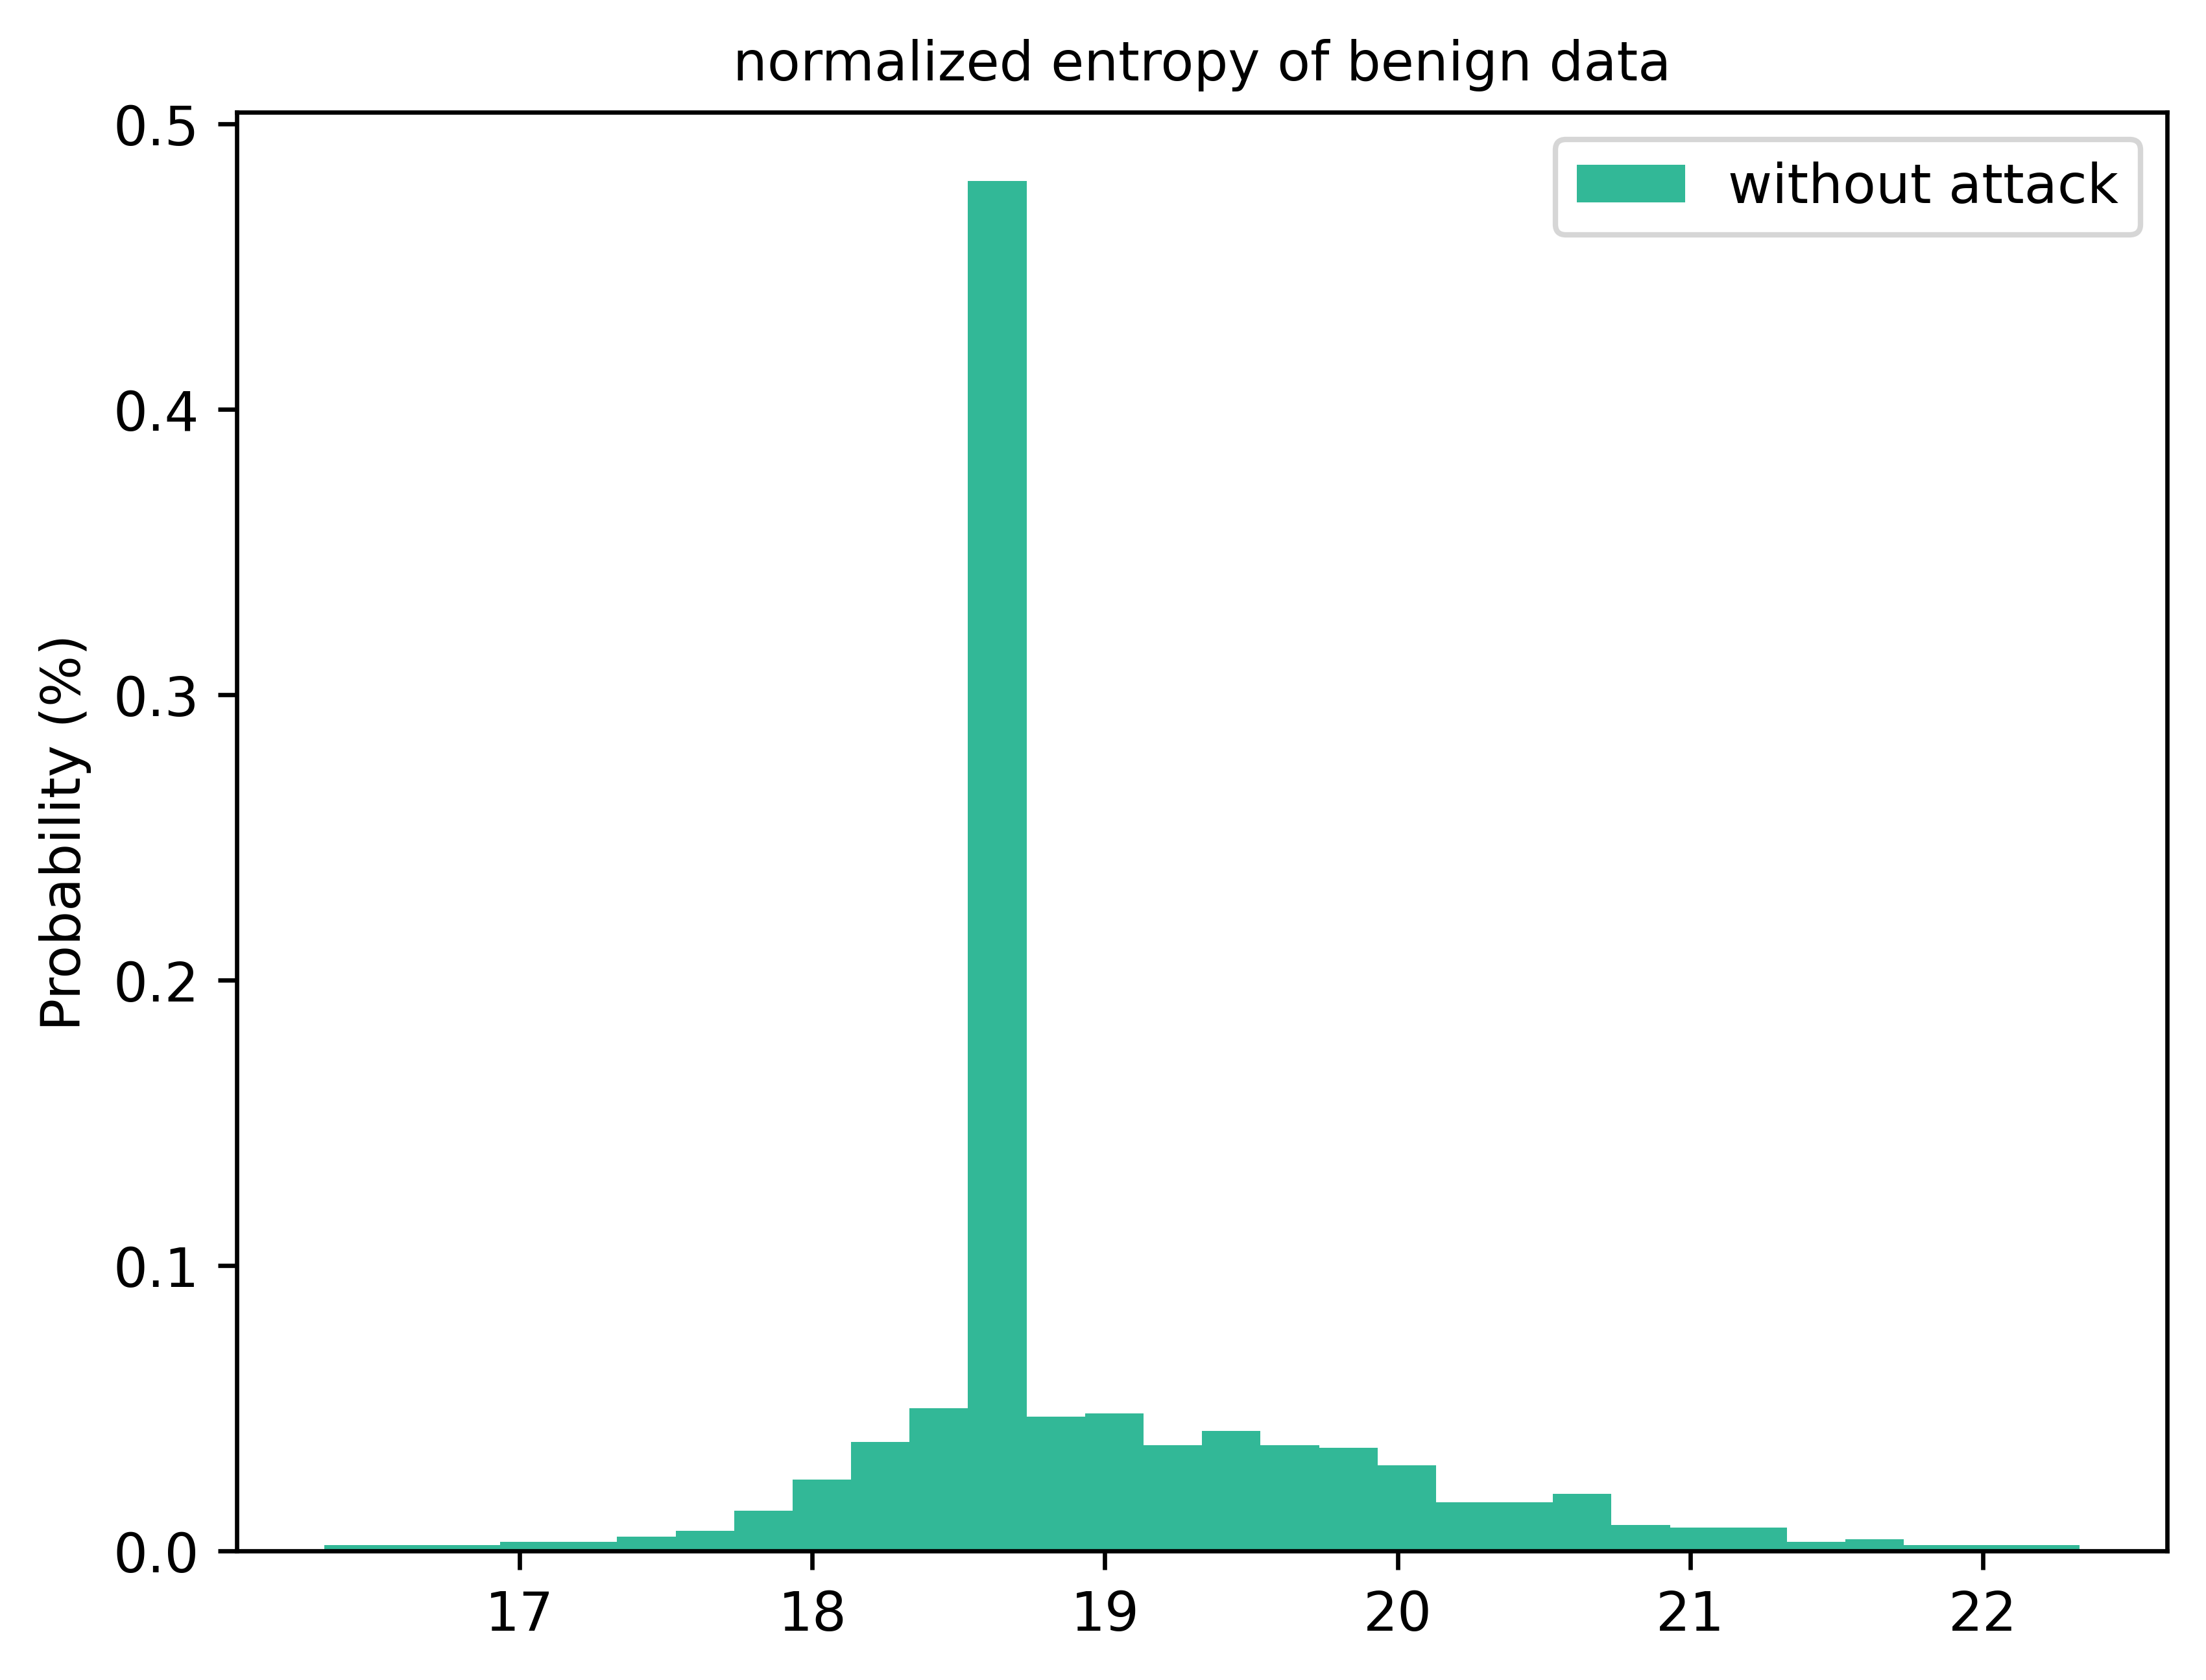

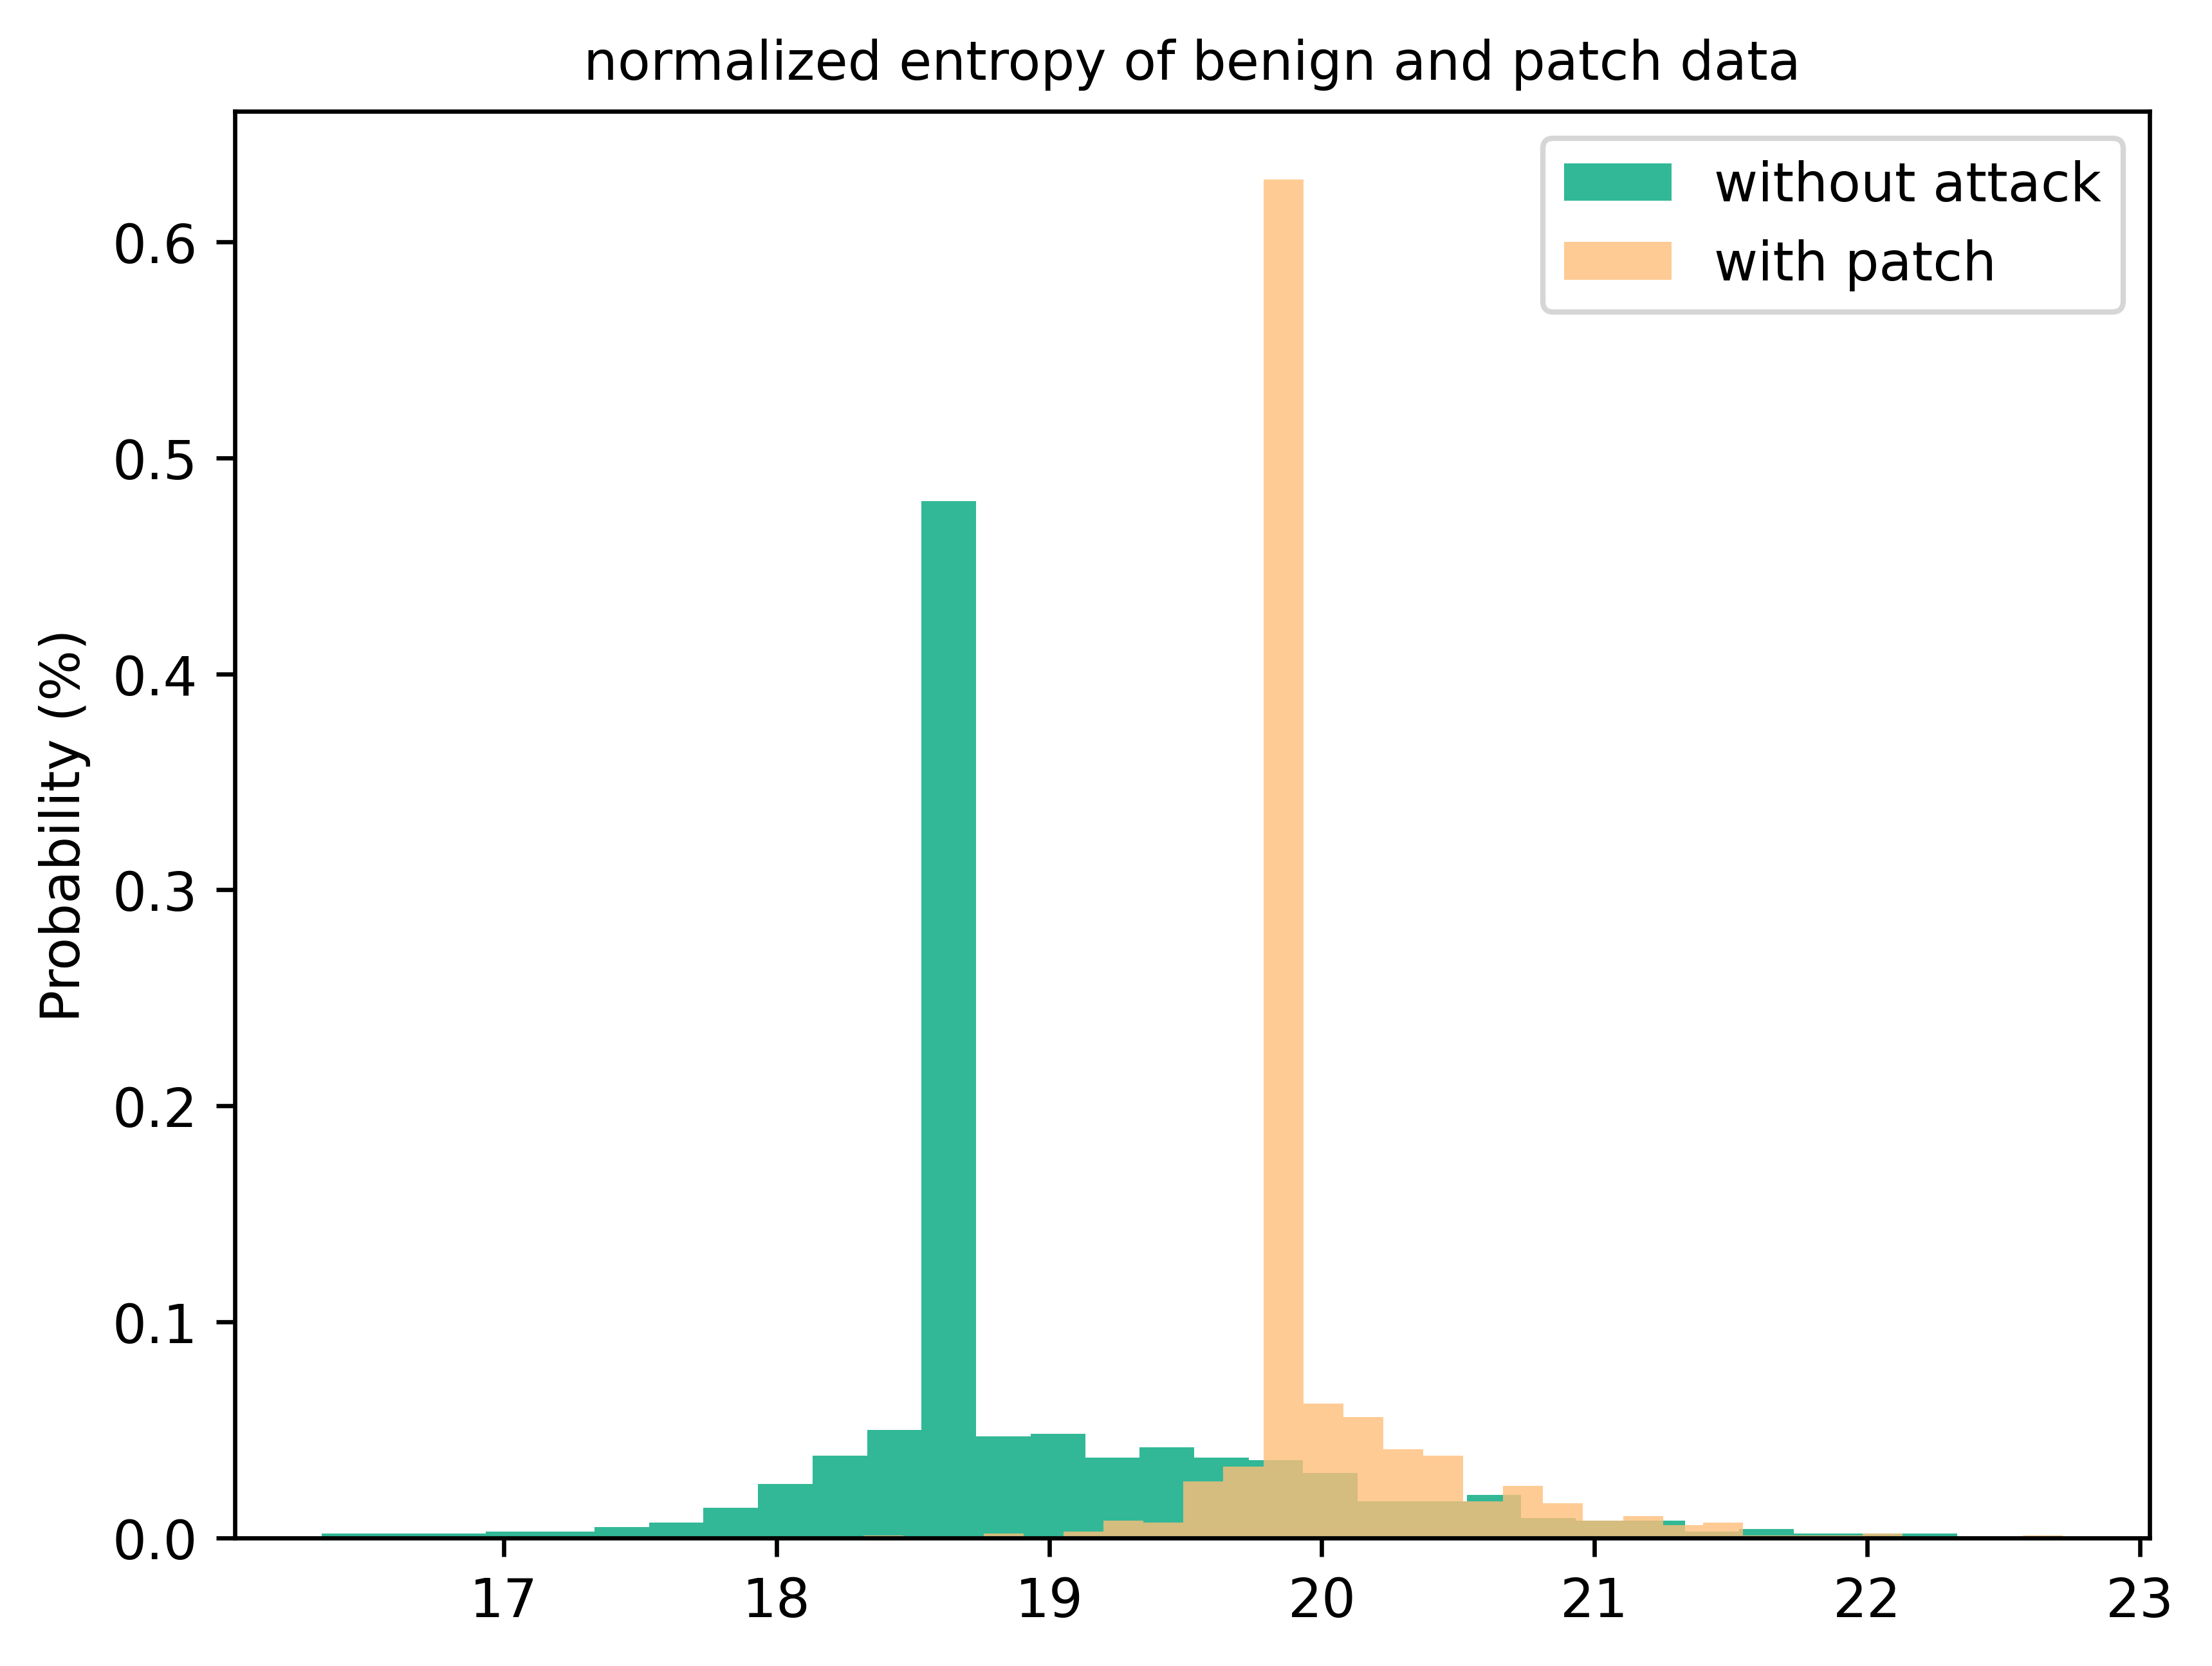

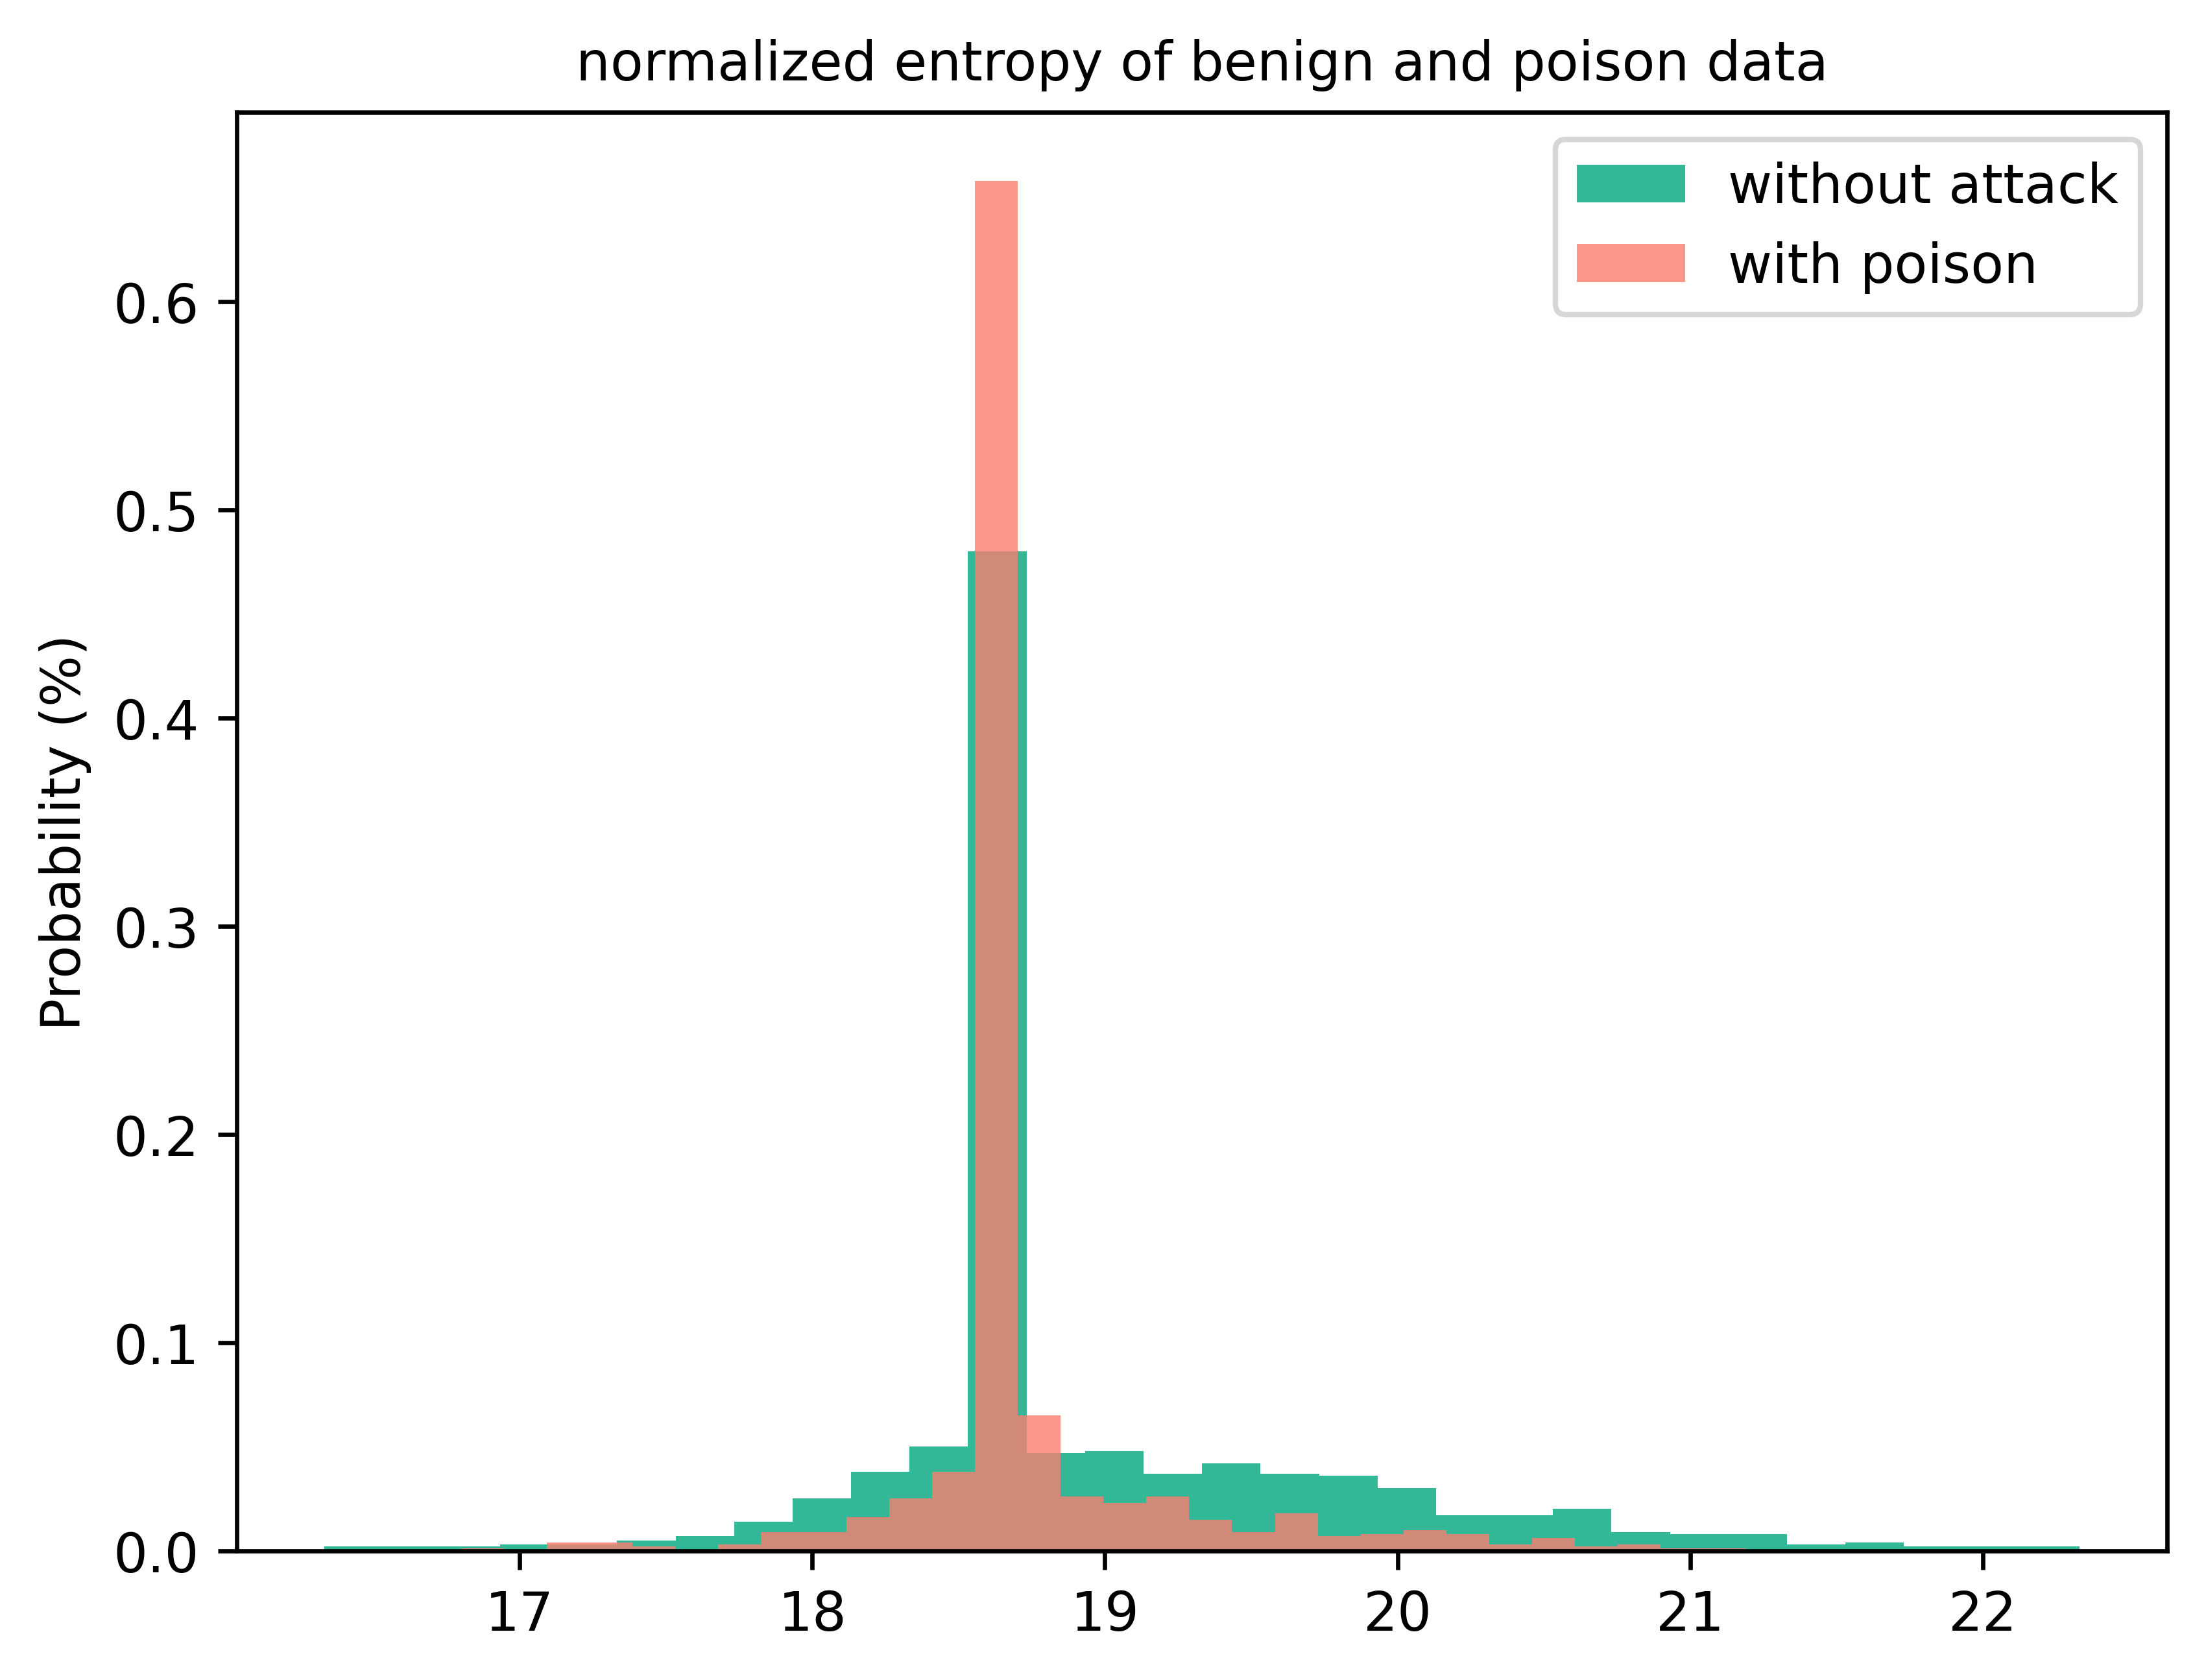

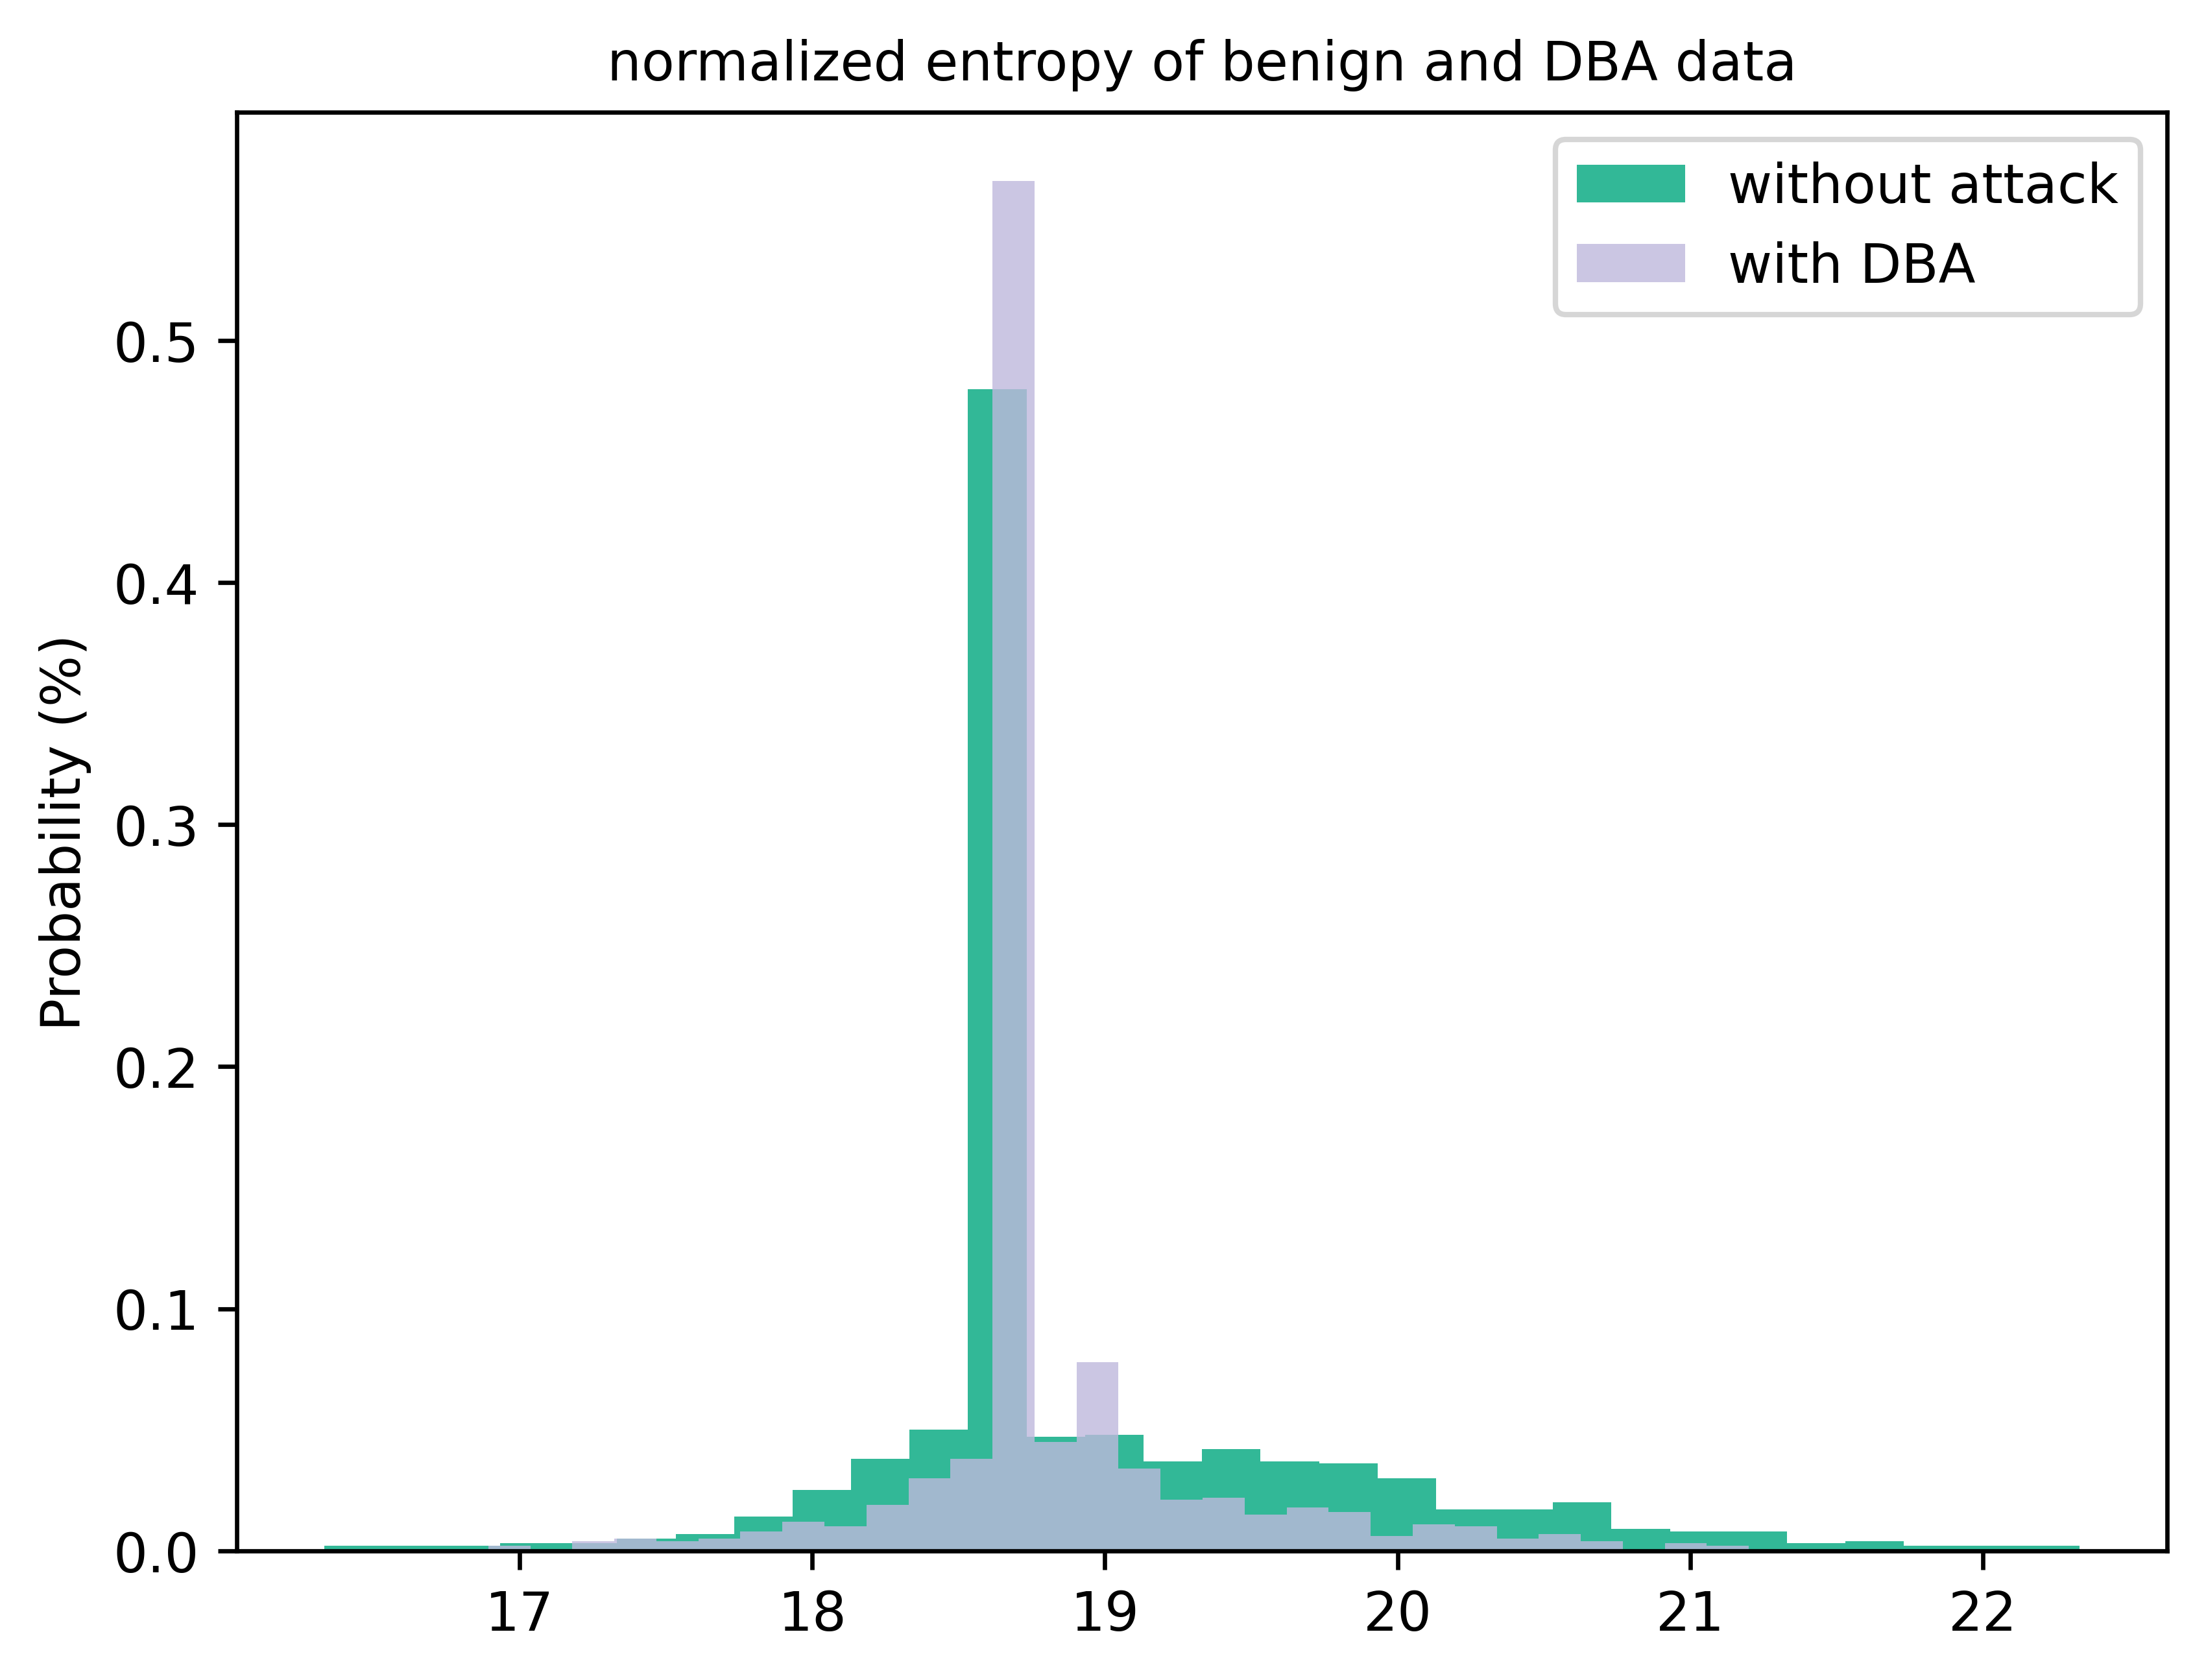

In [27]:
bins = 30
dpi = 600
alpha_b = 1
alpha = 0.8
color_benign = '#32B897'
color_patch = '#FFBE7A'
color_poison = '#FA7F6F'
color_DBA = '#BEB8DC'


plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("X:\Directory\code\exp_org_pic\cifar100/DBA-benign.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack, bins, weights=np.ones(len(EntropySum_attack)) / len(EntropySum_attack), color = color_patch, alpha=alpha, label='with patch')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and patch data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("X:\Directory\code\exp_org_pic\cifar100/DBA-benign2patch.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack_poison, bins, weights=np.ones(len(EntropySum_attack_poison)) / len(EntropySum_attack_poison), color = color_poison, alpha=alpha, label='with poison')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and poison data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("X:\Directory\code\exp_org_pic\cifar100/DBA-benign2poison.tiff")
png1.close()

plt.figure(dpi=dpi)
plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), color = color_benign, alpha=alpha_b, label='without attack')
plt.hist(EntropySum_attack_DBA, bins, weights=np.ones(len(EntropySum_attack_DBA)) / len(EntropySum_attack_DBA), color = color_DBA, alpha=alpha, label='with DBA')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy of benign and DBA data', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
png1 = io.BytesIO()
plt.savefig(png1, format="png", dpi=600, pad_inches = .1, bbox_inches = 'tight')
png2 = Image.open(png1)
# Save as TIFF
png2.save("X:\Directory\code\exp_org_pic\cifar100/DBA-benign2DBA.tiff")
png1.close()
plt.show()

# org && org+trigger 的熵 对比，poison差别不大，patch趋势差别很大，
# no attack 和 poison 和 patch在benign数据下的熵的对比